In [112]:
#Imports
import sys
import sympy
from sympy import *
from sympy.physics.quantum.dagger import Dagger
from IPython.display import display, Latex, Math, Image
sympy.init_printing()
from quik.qip.nmodes_symbolic import Vacuum, CovarianceMatrix
import quik.qip.nmodes
import quik.qip.qkd.cv as cvqkd
from quik.qip.squeezer import Squeezer
import numpy as np
import scipy
import scipy.optimize
import seaborn as sns
import matplotlib.pyplot as plt

# Summary Description

This code simulates a continuous variables quantum key distribution system, based on the 
Gaussian modulation of the squeezed quadrature of an electromagnetic radiation field.
In particular, 

- It computes the prepare & measure covariance matrix of the quantum state shared among the communication parties;
- It performs parameter estimation, to estimate the untrusted channel loss and excess noise, in closed form symbolic expressions;

# System Schematic

In [113]:
Image("Figures/Squeezed-States-QKD_schematic-system-level_prepare-and-measure.png", width=800)

FileNotFoundError: No such file or directory: 'Figures/Squeezed-States-QKD_schematic-system-level_prepare-and-measure.png'

FileNotFoundError: No such file or directory: 'Figures/Squeezed-States-QKD_schematic-system-level_prepare-and-measure.png'

<IPython.core.display.Image object>

# List of Modes of the Quantum Field:

- Tx: mode propagating towards the transmitter's homodyne detector;

- Rx-q: mode propagating towards the receiver's homodyne detector, measuring the antisqueezed ($\hat{q}$) quadrature;

- Rx-p: mode propagating towards the receiver's homodyne detector, measuring the squeezed ($\hat{p}$) quadrature;

- E1, E2: asymmetric two-mode squeezed state prepared by the eavesdropper.


# List of the QKD parameters:


- $n$: real, > 0.

         mean photon number of the thermal state generated by Gaussian modulation of a displaced vacuum state, at the input of the channel.
- $V_s$: real, > 0.

        variance of the squeezed quadrature of the unmodulated signal, at the input of the channel.

- $V_a$: real, > 0.

        variance of the antisqueezed quadrature of the unmodulated signal, at the input of the channel.
- $R_{Tx}$: real, [0, 1]

        power reflectivity of the transmitter/channel beam splitter.  

- $\tau_{Tx}$: real, [0, 1]

            power transmission efficiency from the reflection port of the transmitter/channel beam splitter to the channel input.

- $\tau_A$: real, [0, 1]

        power transmission efficiency from the transmission port of the transmitter/channel beam splitter to the transmitter's homodyne detector (including photodiodes' quantum efficiency).

- $t_A$: real, > 0

        mean photon number corresponding to the thermal noise added by the transmitter's homodyne detector.

- $w_q$, $w_p$: real, > 0

        mean photon number of the excess thermal noise in the state prepared by the eavesdropper, at the channel input
        
- $u_q$, $u_p$: real, > 0

        mean photon number of the excess thermal noise in the state prepared by the eavesdropper, at the receiver's respective homodyne detector

- $c_1$, $c_2$: real

        inter-quadratures correlation coefficients of the asymmetric EPR state.


- $\eta$: real, [0, 1]

        power transmission efficiency of the quantum channel.


- $\tau_{Rx}$: real, [0, 1]

        power transmission efficiency from the channel's output to the receiver's beam splitter input.

- $\tau_q$, $\tau_p$: real, [0, 1]

        power transmission efficiency from the output of the receiver's beam splitter to the input of the receiver's homodyne detector, measuring q, p.

- $R_{Rx}$: real, [0, 1]

        power reflectivity of the receiver's beam splitter.

- $\sigma_{\phi,Tx}$, $\sigma_{\phi,Rx}$: real, > 0

        standard deviation of the homodyne detection phase noise at the transmitter, recevier homodyne detector.

### Define symbols for the QKD parameters 

In [114]:
n, V_s, V_a, R_Tx, tau_Tx, tau_A, t_A, w_q, w_p, eta, tau_Rx, tau_q, tau_p, t_q, t_p, R_Rx, sigma_phi_Tx, sigma_phi_Rx = sympy.symbols('n V_s V_a R_Tx tau_Tx tau_A t_A w_q w_p eta tau_Rx tau_q tau_p t_q t_p R_Rx sigma_phi_Tx sigma_phi_Rx', real=True, nonnegative=True)
c_1, c_2 = sympy.symbols("c_1 c_2", real=True) 
u_q, u_p = sympy.symbols('u_x, u_p', real=True, nonnegative=True) 

### Initialize the total covariance matrix 

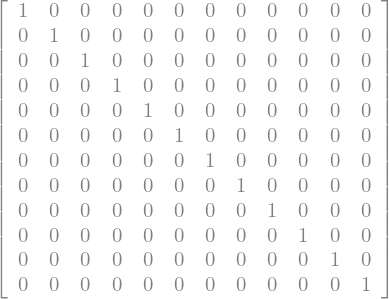

In [115]:
#Initialize in a vacuum state
CM = Vacuum(6)
CM

### Define the Gaussian-modulated single mode squeezed vacuum state

In [116]:
CM[0, 0] = (V_a-(1-R_Tx*tau_Tx))/(R_Tx*tau_Tx)
CM[1, 1] = (V_s-(1-R_Tx*tau_Tx))/(R_Tx*tau_Tx)+2*n/(R_Tx*tau_Tx)

### Define the Gaussian distributed QKD symbols and their covariance with the modulated signal quadrature

Note: this is not a mode of the quantum field, but the covariances transform similarly because of gaussianity of the QKD symbols and gaussianity of the transformations.

In [117]:
#Define the covariance matrix of the QKD symbols as the last mode
#-------------------------------
CM[10, 10] = 0
CM[11, 11] = 2*n/(R_Tx*tau_Tx)
#Introduce correlations between the modulated signal mode and the QKD symbols
CM[1, 11] = CM[11, 1] = 2*n/(R_Tx*tau_Tx)


- Covariance matrix with the signal in a Gaussian-modulated single-mode squeezed vacuum state:


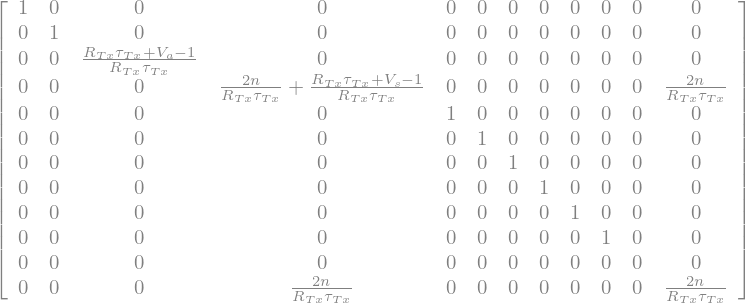

In [118]:
#Re-order the modes for convenience with beam splitting operations
CM = CM.pick_modes(2, 1, 3, 4, 5, 6)
print("\n- Covariance matrix with the signal in a Gaussian-modulated single-mode squeezed vacuum state:")
CM

### Split the signal mode between the channel and the transmitter's homodyne detector
#### The first split mode propagates towards the transmitter's homodyne detector. The second goes towards the channel.


- Covariance matrix after splitting at the transmitter/channel beam splitter:


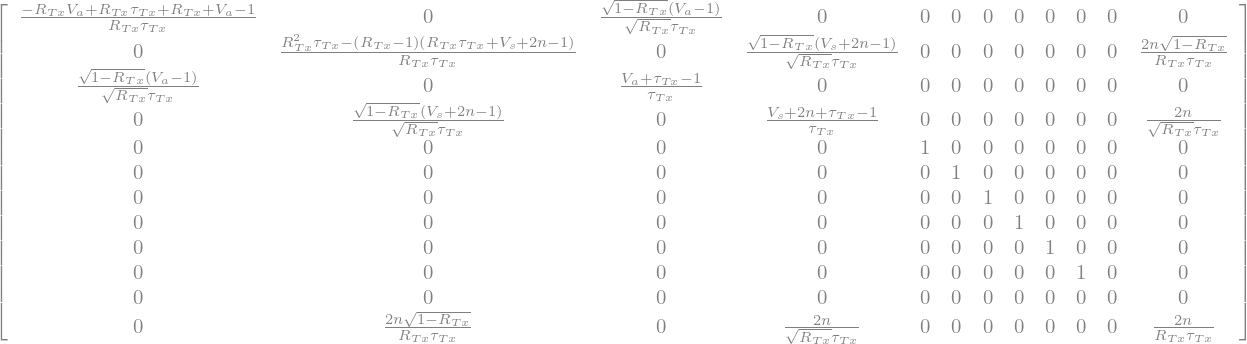

In [119]:
CM = CM.bs(1, 2, R=R_Tx)
print("\n- Covariance matrix after splitting at the transmitter/channel beam splitter:")
sympy.simplify(CM)

### Propagate the signal towards the transmitter's homodyne detector


- Covariance matrix after propagation towards the transmitter's homodyne detector':


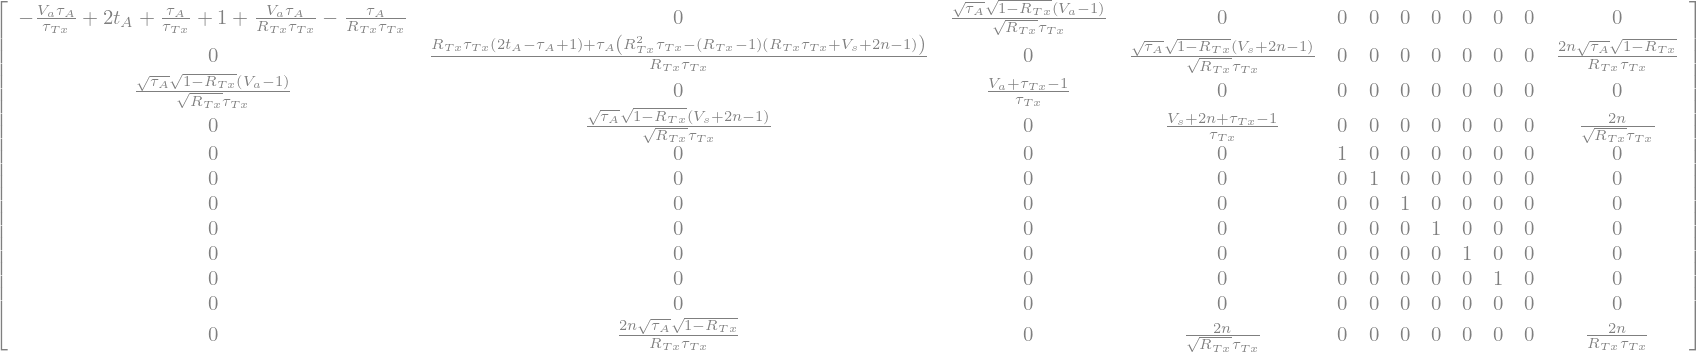

In [120]:
CM = CM.opticalefficiency(tau_A, 1, 1, 1, 1, 1)
CM[0, 0] += 2*t_A #detector noise
CM[1, 1] += 2*t_A #detector noise
print("\n- Covariance matrix after propagation towards the transmitter's homodyne detector':")
sympy.simplify(CM)

### Propagate the reflected signal to the channel input


- Covariance matrix after propagation to the input of the quantum channel:


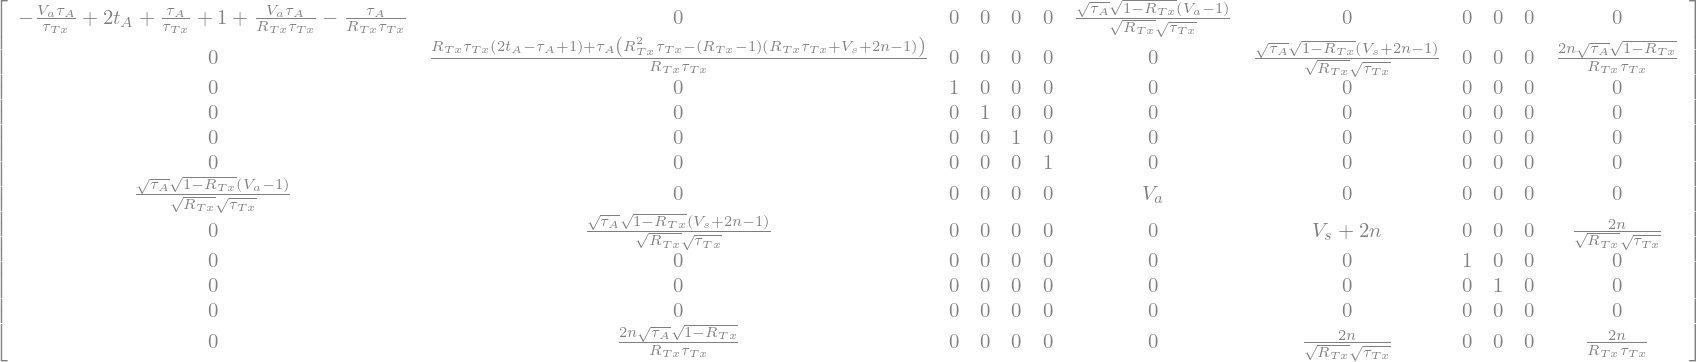

In [121]:
CM = CM.opticalefficiency(1, tau_Tx, 1, 1, 1, 1)
#Exchange the order of the modes for convenience with beam splitting operations
CM = CM.pick_modes(1, 3, 4, 2, 5, 6)
print("\n- Covariance matrix after propagation to the input of the quantum channel:")
sympy.simplify(CM)

### Define the asymmetric EPR state prepared by the eavesdropper


- Covariance matrix with the eavesdropper's two-mode squeezed vacuum state':


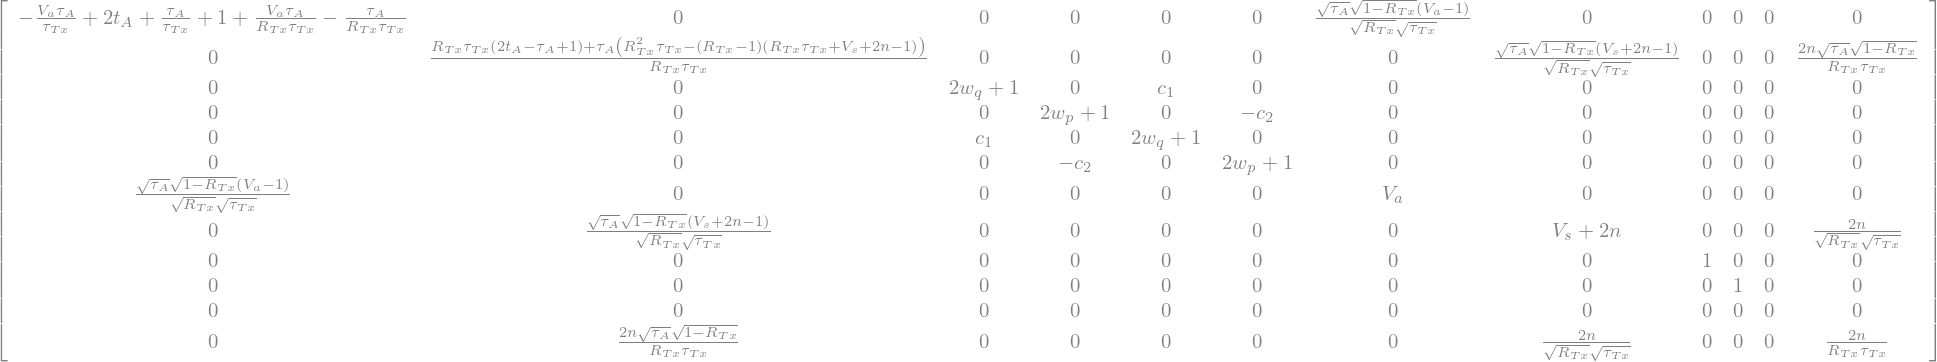

In [122]:
CM[2, 2] = CM[4, 4] = 2*w_q+1
CM[3, 3] = CM[5, 5] = 2*w_p+1
CM[2, 4] = CM[4, 2] = c_1
CM[3, 5] = CM[5, 3] = -c_2
print("\n- Covariance matrix with the eavesdropper's two-mode squeezed vacuum state':")
sympy.simplify(CM)

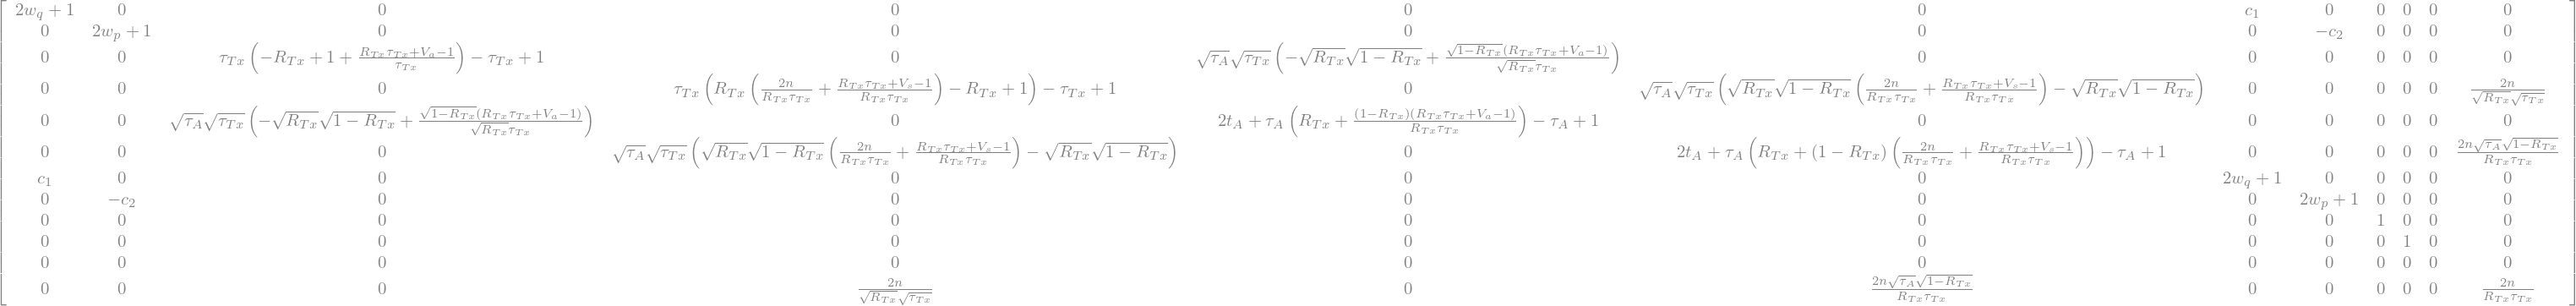

In [52]:
CM.pick_modes(2, 4, 1, 3, 5, 6)

### Interfere the first eavesdropper's mode and the propagating signal mode on the channel

In [53]:
CM = CM.bs(2, 4, R=1-eta)


- Covariance matrix after interfering the signal and the eavesdropper's first mode on the quantum channel:


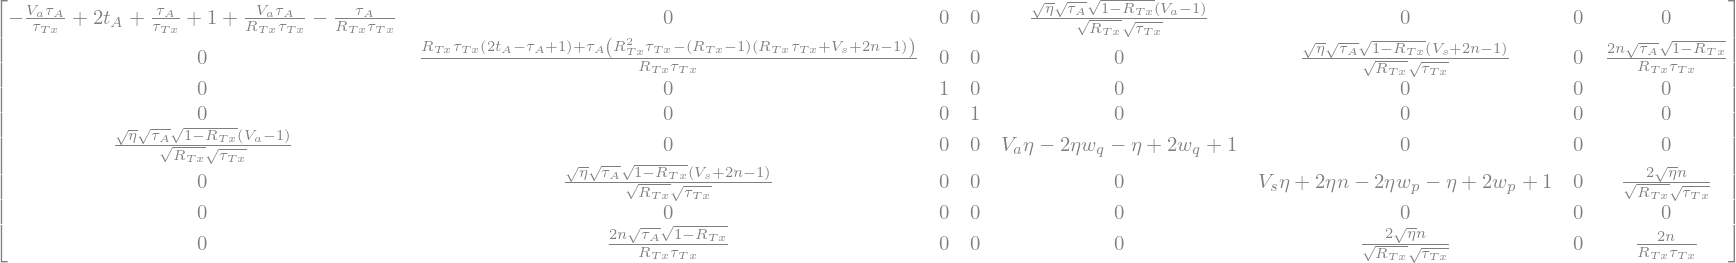

In [54]:
#discard the second eavesdropper's mode and the one propagating to the eavesdropper's measurement device 
#and re-order the modes
CM = CM.pick_modes(1, 5, 2, 6) 
print("\n- Covariance matrix after interfering the signal and the eavesdropper's first mode on the quantum channel:")
sympy.simplify(CM)

### Propagate the signal toward the input of the receiver's beam splitter


- Covariance matrix after propagation to the receiver's beam splitter:


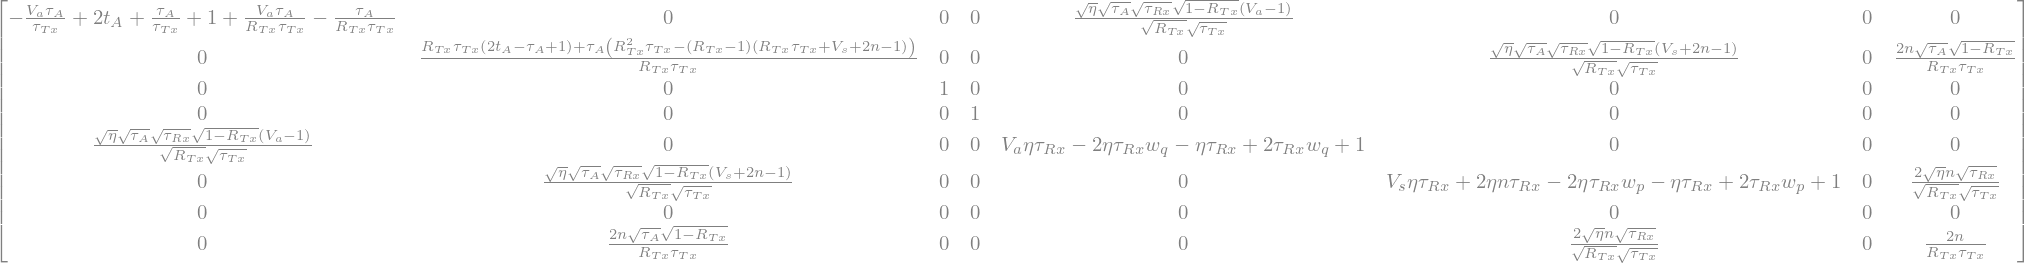

In [55]:
CM = CM.opticalefficiency(1, 1, tau_Rx, 1)
print("\n- Covariance matrix after propagation to the receiver's beam splitter:")
sympy.simplify(CM)

### Split the signal at the receiver's beam splitter
#### The first split mode propagates towards the receiver's homodyne detector measuring $\hat{p}$, The second goes towards the homodyne detector measuring $\hat{q}$.


- Covariance matrix after splitting at the receiver's beam splitter:


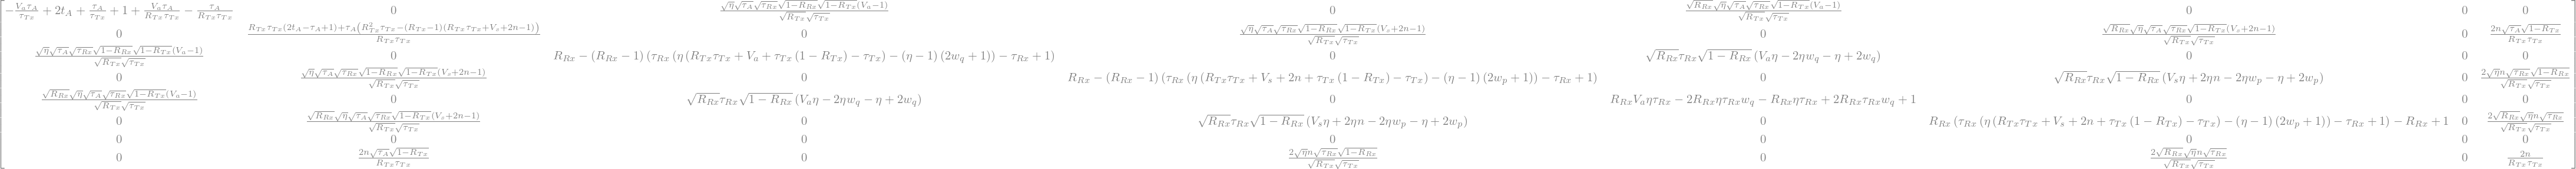

In [56]:
CM = CM.bs(2, 3, R=R_Rx)
print("\n- Covariance matrix after splitting at the receiver's beam splitter:")
sympy.simplify(CM)

### Propagate the receiver signals towards the respective homodyne detectors


- Covariance matrix after propagation towards the receiver's homodyne detectors:


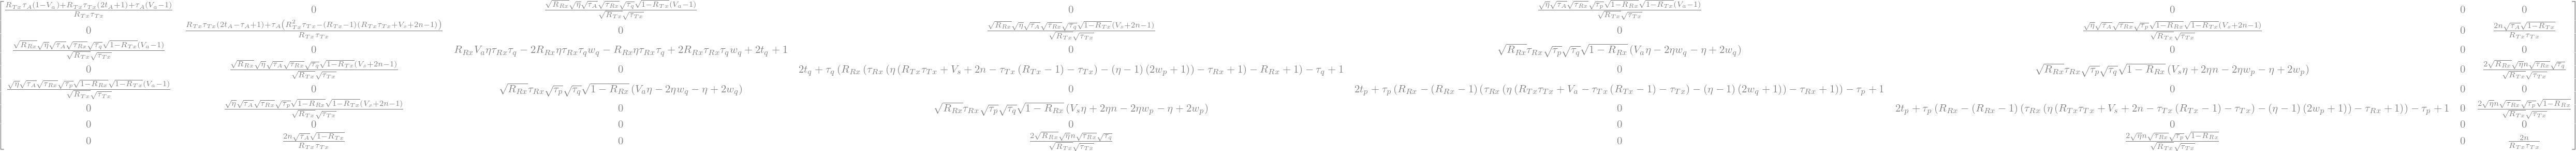

In [57]:
#q
CM = CM.opticalefficiency(1, 1, tau_q, 1)
CM[4, 4] += 2*t_q
CM[5, 5] += 2*t_q
#p
CM = CM.opticalefficiency(1, tau_p, 1, 1)
CM[2, 2] += 2*t_p
CM[3, 3] += 2*t_p
#Re-order the modes
CM = CM.pick_modes(1, 3, 2, 4)
print("\n- Covariance matrix after propagation towards the receiver's homodyne detectors:")
CM = CovarianceMatrix(sympy.simplify(CM))
sympy.simplify(CM)

# Parameter Estimation 
-----------------

## Back-to-back configuration: 
It is the version of the QKD system where the untrusted excess noise is zero, i.e., $w_{q,p}=0$.

### Define the back-to-back covariance matrix and its entries
- $x_{q,b2b}$: variance of the $\hat{q}$ quadrature of mode 1 (measured by the transmitter's homodyne detector);
- $y_{q,b2b}$: variance of the $\hat{q}$ quadrature of mode 2 (measured by the receiver's homodyne detector $\hat{q}$);
- $y_{p,b2b}$: variance of the $\hat{p}$ quadrature of mode 3 (measured by the receiver's homodyne detector $\hat{p}$);
- $y_{p,b2b,nomod}$: variance of the $\hat{p}$ quadrature of mode 3 (measured by the receiver's homodyne detector $\hat{p}$), without modulation ($n=0$);
- $y_{p,b2b,orthogonal,nomod}$: variance of the $\hat{q}$ quadrature of mode 3 (measured by the receiver's homodyne detector $\hat{p}$), without modulation ($n=0$);
- $z_{q,b2b}$: covariance between the $\hat{q}$ quadratures of modes 1 and 2;
- $z_{p,b2b}$: covariance between the $\hat{p}$ quadratures of modes 3 and 4;
- $\eta_{b2b}$: untrusted channel efficiency in the b2b measurement.

In [23]:
x_q_b2b, y_q_b2b, y_p_b2b, z_q_b2b, z_p_b2b = sympy.symbols("x_q_b2b y_q_b2b y_p_b2b z_q_b2b, z_p_b2b", real=True, nonnegative=True)
eta_b2b = sympy.symbols("eta_b2b", real=True, nonnegative=True)

### Define the measured variance of the $\hat{p}$ quadrature of mode 3, with no modulation ($n$=0)

In [24]:
y_p_b2b_no_mod = sympy.symbols("y_p_b2b_no_mod", real=True, nonnegative=True)
y_p_orthogonal_b2b_no_mod = sympy.symbols("y_p_orthogonal_b2b_no_mod", real=True, nonnegative=True)

### Calculate the expression of the back-to-back covariance matrix, by setting the excess noise to 0


- Covariance matrix in the back-to-back configuration:


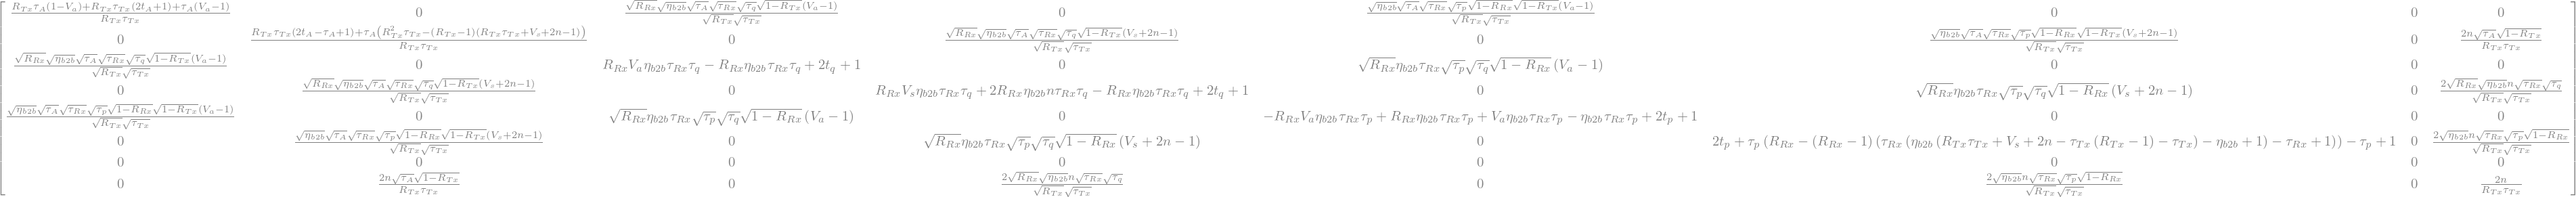

In [25]:
CM_b2b = CM.subs([(eta, eta_b2b), (w_q, 0), (w_p, 0)])
print("\n- Covariance matrix in the back-to-back configuration:")
sympy.simplify(CM_b2b)

### Estimate the following parameters from the back-to-back configuration

- $V_s$;
- $V_a$;
- $n$;
- $\eta_{b2b}$;
- $R_\text{Tx}$;
- $R_\text{Rx}$.

In [26]:
#System of equations
system = [Eq(CM_b2b[5, 5].subs([(n, 0)])-y_p_b2b_no_mod, 0), 
          Eq(CM_b2b[5, 5]-y_p_b2b, 0),
          Eq(CM_b2b[0, 0]-x_q_b2b, 0),
          Eq(CM_b2b[2, 2]-y_q_b2b, 0), 
          Eq(CM_b2b[4, 4]-y_p_orthogonal_b2b_no_mod, 0),
          Eq(CM_b2b[2, 0]-z_q_b2b, 0)]
print("Equations to be solved simultaneously:")

Equations to be solved simultaneously:


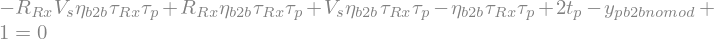

In [27]:
sympy.simplify(system[0])

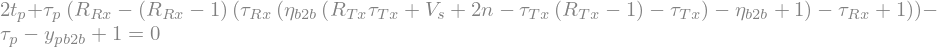

In [28]:
sympy.simplify(system[1])

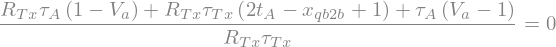

In [29]:
sympy.simplify(system[2])

In [30]:
sympy.simplify(system[3])

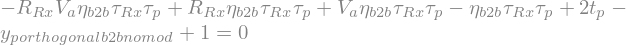

In [31]:
sympy.simplify(system[4])

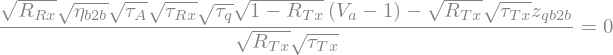

In [32]:
sympy.simplify(system[5])

In [87]:
parameters_b2b = sympy.solve(system, [V_s, V_a, n, eta_b2b, R_Tx], dict=True)
print("\n- Parameters estimated in the back-to-back configuration:")
parameters_b2b

UnboundLocalError: local variable 'solved_syms' referenced before assignment

In [34]:
#Print the result in python code format
print("\nBack-to-back parameters in python code format:\n")
print(parameters_b2b)
print(latex(parameters_b2b))


Back-to-back parameters in python code format:

[]
\left[ \right]


### Define the covariance matrix entries

- $y_q$: variance of the $\hat{q}$ quadrature of mode 2;
- $y_p$: variance of the $\hat{p}$ quadrature of mode 3;
- $z_q$: covariance between the $\hat{q}$ quadratures of modes 1 and 2;
- $z_p$: covariance between the $\hat{p}$ quadrature of mode 3 and the modulation signal.

In [33]:
y_q, y_p = sympy.symbols("y_q, y_p", real=True, nonnegative=True)
x_q, y_p_no_mod = sympy.symbols("x_q, y_p_nomod", real=True, nonnegative=True)
z_q, z_p = sympy.symbols("z_q z_p", real=True)

### Define the untrusted parameters

- $\eta_q$: channel efficiency for the $\hat{q}$ quadrature;
- $\eta_p$: channel efficiency for the $\hat{p}$ quadrature;
- $u_q$: untrusted noise mean photon number for the $\hat{q}$ quadrature;
- $u_p$: untrusted noise mean photon number for the $\hat{p}$ quadrature;

In [73]:
eta_q, eta_p, u_q, u_p = sympy.symbols("eta_q eta_p u_q u_p", real=True)

### Estimate the untrusted channel efficiency and the untrusted excess noise

In [92]:
system = (Eq(CM[2, 2].subs([(eta, eta_q)])-y_q, 0), 
          Eq(CM[5, 5].subs([(eta, eta_p)])-y_p, 0), 
          Eq(CM[0, 2].subs([(eta, eta_q)])-z_q, 0),  
          Eq(CM[5, 7].subs([(eta, eta_p)])-z_p, 0)) 
print("Equations to be solved simultaneously:")

Equations to be solved simultaneously:


In [95]:
print(system[0])
sympy.factor(sympy.simplify(system[0]))

Eq(R_Rx*V_a*eta_q*tau_Rx*tau_q - 2*R_Rx*eta_q*tau_Rx*tau_q*w_q - R_Rx*eta_q*tau_Rx*tau_q + 2*R_Rx*tau_Rx*tau_q*w_q + 2*t_q - y_q + 1, 0)


Eq(2*t_p + tau_p*(R_Rx - (R_Rx - 1)*(tau_Rx*(eta_p*(R_Tx*tau_Tx + V_a + 2*n + tau_Tx*(1 - R_Tx) - tau_Tx) - (eta_p - 1)*(2*w_p + 1)) - tau_Rx + 1)) - tau_p - y_p + 1, 0)


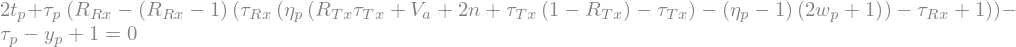

In [38]:
print(system[1])
system[1]

Eq(sqrt(R_Rx)*sqrt(eta_q)*sqrt(tau_A)*sqrt(tau_Rx)*sqrt(tau_q)*sqrt(1 - R_Tx)*(V_a - 1)/(sqrt(R_Tx)*sqrt(tau_Tx)) - z_q, 0)


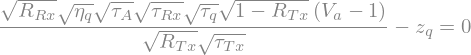

In [39]:
print(system[2])
system[2]

Eq(-z_p + 2*sqrt(eta_p)*n*sqrt(tau_Rx)*sqrt(tau_p)*sqrt(1 - R_Rx)/(sqrt(R_Tx)*sqrt(tau_Tx)), 0)


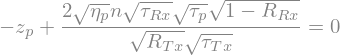

In [40]:
print(system[3])
system[3]


- Estimated untrusted channel efficiency and excess noise mean photon number:


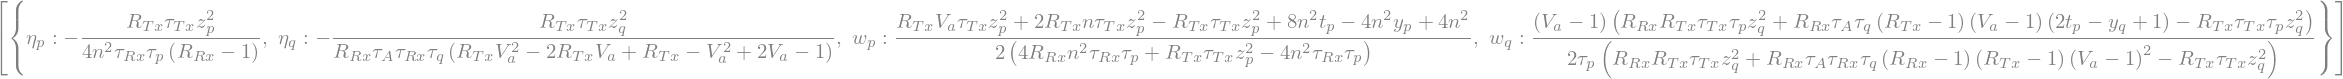

In [41]:
#Solve the system of equations with respect to (eta_q, eta_p, u_q, u_p)
parameters = sympy.solve(system, (eta_q, eta_p, w_q, w_p), dict=True)
print("\n- Estimated untrusted channel efficiency and excess noise mean photon number:")
parameters

In [36]:
print(latex(parameters))

\left[ \left\{ \eta_{p} : - \frac{z_{p}^{2}}{4 R_{Tx} n^{2} \tau_{Rx} \tau_{Tx} \tau_{p} \left(R_{Rx} - 1\right)}, \  \eta_{q} : - \frac{z_{q}^{2}}{R_{Rx} R_{Tx} \tau_{A} \tau_{Rx} \tau_{Tx} \tau_{q} \left(R_{Tx} V_{a}^{2} - 2 R_{Tx} V_{a} + R_{Tx} - V_{a}^{2} + 2 V_{a} - 1\right)}, \  w_{p} : \frac{R_{Tx} \tau_{Tx} \left(V_{s} z_{p}^{2} + 8 n^{2} t_{p} - 4 n^{2} y_{p} + 4 n^{2} + 2 n z_{p}^{2} - z_{p}^{2}\right)}{2 \left(4 R_{Rx} R_{Tx} n^{2} \tau_{Rx} \tau_{Tx} \tau_{p} - 4 R_{Tx} n^{2} \tau_{Rx} \tau_{Tx} \tau_{p} + z_{p}^{2}\right)}, \  w_{q} : - \frac{R_{Tx} \tau_{Tx} \left(- V_{a} z_{q}^{2} + \tau_{A} \left(R_{Tx} - 1\right) \left(V_{a} - 1\right)^{2} \left(2 t_{q} - y_{q} + 1\right) + z_{q}^{2}\right)}{2 R_{Rx} R_{Tx} \tau_{A} \tau_{Rx} \tau_{Tx} \tau_{q} \left(R_{Tx} - 1\right) \left(V_{a} - 1\right)^{2} + 2 z_{q}^{2}}\right\}\right]


In [39]:
#Print the result in python code format
print("\nUntrusted parameters in python code format:\n")
print(parameters)


Untrusted parameters in python code format:

[{eta_p: -z_p**2/(4*R_Tx*n**2*tau_Rx*tau_Tx*tau_p*(R_Rx - 1)), eta_q: -z_q**2/(R_Rx*R_Tx*tau_A*tau_Rx*tau_Tx*tau_q*(R_Tx*V_a**2 - 2*R_Tx*V_a + R_Tx - V_a**2 + 2*V_a - 1)), w_p: R_Tx*tau_Tx*(V_s*z_p**2 + 8*n**2*t_p - 4*n**2*y_p + 4*n**2 + 2*n*z_p**2 - z_p**2)/(2*(4*R_Rx*R_Tx*n**2*tau_Rx*tau_Tx*tau_p - 4*R_Tx*n**2*tau_Rx*tau_Tx*tau_p + z_p**2)), w_q: R_Tx*tau_Tx*(V_a - 1)*(R_Rx*tau_A*tau_q*(R_Tx - 1)*(V_a - 1)*(2*t_p - y_q + 1) + R_Rx*tau_p*z_q**2 - tau_p*z_q**2)/(2*tau_p*(R_Rx*R_Tx*tau_A*tau_Rx*tau_Tx*tau_q*(R_Rx - 1)*(R_Tx - 1)*(V_a - 1)**2 + R_Rx*z_q**2 - z_q**2))}]


## Parameter Estimation with Minimum Number of Trusted Parameters

#### Scope

find a parameter estimation procedure that requires explicit values of the least number of trusted parameters. This can be useful to simplify parameter estimation and to not having to rely on a possibly inaccurate measurement of some experimental parameters.

### Define the entries of the prepare & measure covariance matrix

- $V^{(\text{Tx})}_q$: variance of the $\hat{q}$ quadrature detected at homodomdyne detector Tx

- $V^{(\text{Rx-q})}_q$: variance of the $\hat{q}$ quadrature detected at homodomdyne detector Rx-q

- $V^{(\text{Rx-p})}_q$: variance of the $\hat{q}$ quadrature detected at homodomdyne detector Rx-p

- $V^{(\text{Rx-p})}_p$: variance of the $\hat{p}$ quadrature detected at homodomdyne detector Rx-p

- $V^{(\text{Rx-p})}_{p, nomod}$: variance of the $\hat{p}$ quadrature detected at homodomdyne detector Rx-p without modulation ($n=0$)

- $C^{(\text{Tx, Rx-q})}_q$: covariance between the $\hat{q}$ quadratures detected at homodyne detectors Tx and Rx-q

- $C^{(\text{Tx, Rx-p})}_q$: covariance between the $\hat{q}$ quadratures detected at homodyne detectors Tx and Rx-p

- $C^{(\text{mod, Rx-p})}_p$: covariance between the $\hat{p}$ quadrature detected at homodyne detector Rx-p and the generated QKD symbols



In [58]:
V_q_Tx, V_q_Rx_q, V_q_Rx_p, V_p_Rx_p, V_p_nomod_Rx_p, C_q_Tx_Rx_q, C_q_Tx_Rx_p, C_p_mod_Rx_p=\
sympy.symbols("V^{(Tx)}_q, V^{(Rx-q)}_q  V^{(Rx-p)}_q  V^{(Rx-p)}_p  V^{(Rx-p)}_{p\ nomod}  C^{(Tx\ Rx-q)}_q  C^{(Tx\ Rx-p)}_q  C^{(mod\ Rx-p)}_p", real=True, nonnegative=True)

### Define the following compound quantities:

- $U^{(\text{Rx-q})}_q := R_\text{Rx} \tau_\text{Rx} \tau_q (V_a-1)$: appearing in the variance $V_q^{(\text{Rx-q})}$

- $U^{(\text{Rx-p})}_q := (1-R_\text{Rx}) \tau_\text{Rx} \tau_p (V_a-1)$: appearing in the variance $V_q^{(\text{Rx-p})}$

- $U^{(\text{Rx-p})}_p := (1-R_\text{Rx}) \tau_\text{Rx} \tau_p (V_s+2 n -1)$: appearing in the variance $V_p^{(\text{Rx-p})}$

- $U^{(\text{Rx-p})}_{p, nomod} := (1-R_\text{Rx}) \tau_\text{Rx} \tau_p (V_s-1)$: appearing in the variance $V_p^{(\text{Rx-p})}$ without modulation ($n=0$)

- $K^{(\text{Tx, Rx-q})}_q := \sqrt{\frac{R_\text{Rx}\tau_\text{A}\tau_\text{Rx}\tau_q(1-R_\text{Tx})}{R_\text{Tx}\tau_\text{Tx}}}(V_a-1)$: appearing in the covariance $\text{C}_q^{(\text{Tx, Rx-q})}$

- $K^{(\text{Tx, Rx-p})}_q := \sqrt{\frac{(1-R_\text{Rx})\tau_\text{A}\tau_\text{Rx}\tau_p(1-R_\text{Tx})}{R_\text{Tx}\tau_\text{Tx}}}(V_a-1)$: appearing in the covariance $\text{C}_q^{(\text{Tx, Rx-p})}$

- $K^{(\text{mod, Rx-p})}_p := \sqrt{\frac{(1-R_\text{Rx})\tau_\text{Rx}\tau_p}{R_\text{Tx}\tau_\text{Tx}}}2 n$: appearing in the covariance $\text{C}_p^{(\text{mod, Rx-p})}$

They can be estimated directly from a back-to-back measurement, assuming ($\eta_\text{b2b} = 1$).

In [19]:
U_q_Rx_q, U_q_Rx_p, U_p_Rx_p, U_p_nomod_Rx_p, K_q_Tx_Rx_q, K_q_Tx_Rx_p, K_p_mod_Rx_p=\
sympy.symbols("U^{(Rx-q)}_q  U^{(Rx-p)}_q  U^{(Rx-p)}_p  U^{(Rx-p)}_{p\ nomod}  K^{(Tx\ Rx-q)}_q  K^{(Tx\ Rx-p)}_q  K^{(mod\ Rx-p)}_p", real=True)

In [33]:
eq_variance_1 = Eq(2*w_q*R_Rx*tau_Rx*tau_q*(1-eta)+eta*U_q_Rx_q, V_q_Rx_q - 2*t_q - 1)

eq_variance_2 = Eq(2*w_q*(1-R_Rx)*tau_Rx*tau_p*(1-eta)+eta*U_q_Rx_p, V_q_Rx_p - 2*t_p - 1)

eq_variance_3 = Eq(2*w_p*(1-R_Rx)*tau_Rx*tau_p*(1-eta)+eta*U_p_Rx_p, V_p_Rx_p - 2*t_p - 1)

eq_variance_4 = Eq(2*w_p*(1-R_Rx)*tau_Rx*tau_p*(1-eta)+eta*U_p_nomod_Rx_p, V_p_nomod_Rx_p - 2*t_p - 1)

eq_covariance = Eq(C_q_Tx_Rx_p, sympy.sqrt(eta)*K_q_Tx_Rx_p)

system = (eq_variance_1, eq_variance_2, eq_variance_3, eq_variance_4, eq_covariance)

In [23]:
print(system[0])
system[0]

Eq(2*R_Rx*tau_Rx*tau_q*w_q*(1 - eta) + U^{(Rx-q)}_q*eta, V^{(Rx-q)}_q - 2*t_q - 1)


In [24]:
print(system[1])
system[1]

Eq(U^{(Rx-p)}_q*eta + 2*tau_Rx*tau_p*w_q*(1 - R_Rx)*(1 - eta), V^{(Rx-p)}_q - 2*t_p - 1)


In [25]:
print(system[2])
system[2]

Eq(U^{(Rx-p)}_p*eta + 2*tau_Rx*tau_p*w_p*(1 - R_Rx)*(1 - eta), V^{(Rx-p)}_p - 2*t_p - 1)


In [26]:
print(system[3])
system[3]

Eq(U^{(Rx-p)}_{p nomod}*eta + 2*tau_Rx*tau_p*w_p*(1 - R_Rx)*(1 - eta), V^{(Rx-p)}_{p nomod} - 2*t_p - 1)


In [27]:
print(system[4])
system[4]

Eq(C^{(Tx Rx-p)}_q, K^{(Tx Rx-p)}_q*sqrt(eta))



- Estimated untrusted channel efficiency and excess noise mean photon number:


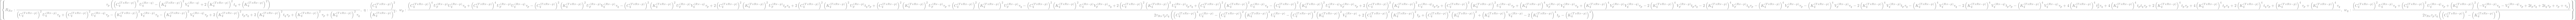

In [39]:
#Solve the system of equations with respect to (eta_q, eta_p, u_q, u_p)
parameters = sympy.solve((system[0], system[1], system[2], system[4]), (eta, w_q, w_p, R_Rx), dict=True)
print("\n- Estimated untrusted channel efficiency and excess noise mean photon number:")
parameters

In [38]:
print(latex(parameters))

#Print the result in python code format
print("\nUntrusted parameters in python code format:\n")
print(parameters)

\left[ \left\{ R_{Rx} : \frac{\tau_{p} \left(\left(C^{(Tx Rx-p)}_q\right)^{2} U^{(Rx-q)}_q - \left(K^{(Tx Rx-p)}_q\right)^{2} V^{(Rx-q)}_q + 2 \left(K^{(Tx Rx-p)}_q\right)^{2} t_{q} + \left(K^{(Tx Rx-p)}_q\right)^{2}\right)}{\left(C^{(Tx Rx-p)}_q\right)^{2} U^{(Rx-p)}_q \tau_{q} + \left(C^{(Tx Rx-p)}_q\right)^{2} U^{(Rx-q)}_q \tau_{p} - \left(K^{(Tx Rx-p)}_q\right)^{2} V^{(Rx-p)}_q \tau_{q} - \left(K^{(Tx Rx-p)}_q\right)^{2} V^{(Rx-q)}_q \tau_{p} + 2 \left(K^{(Tx Rx-p)}_q\right)^{2} t_{p} \tau_{q} + 2 \left(K^{(Tx Rx-p)}_q\right)^{2} t_{q} \tau_{p} + \left(K^{(Tx Rx-p)}_q\right)^{2} \tau_{p} + \left(K^{(Tx Rx-p)}_q\right)^{2} \tau_{q}}, \  \eta : \frac{\left(C^{(Tx Rx-p)}_q\right)^{2}}{\left(K^{(Tx Rx-p)}_q\right)^{2}}, \  w_{p} : \frac{\left(C^{(Tx Rx-p)}_q\right)^{4} U^{(Rx-p)}_p U^{(Rx-p)}_q \tau_{q} + \left(C^{(Tx Rx-p)}_q\right)^{4} U^{(Rx-p)}_p U^{(Rx-q)}_q \tau_{p} - \left(C^{(Tx Rx-p)}_q\right)^{2} \left(K^{(Tx Rx-p)}_q\right)^{2} U^{(Rx-p)}_p V^{(Rx-p)}_q \tau_{q} - \left(C^{(

#### Solve the system by subsequent substitutions

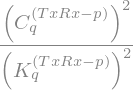

In [62]:
#Solve for the loss
eta_sol = sympy.simplify(sympy.solve(eq_covariance, eta)[0])
eta_sol

substitution of eta:


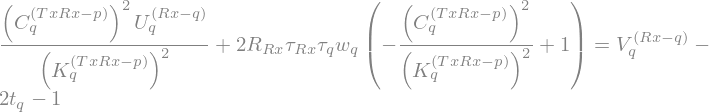

In [63]:
#Substitute in the next equation
eq_variance_1_subs = eq_variance_1.subs([(eta, eta_sol)])
print("substitution of eta:")
eq_variance_1_subs

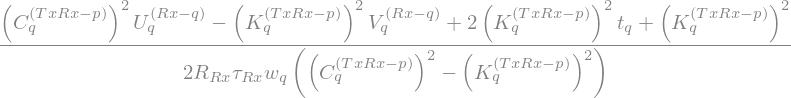

In [64]:
#Substitute solve for tau_q
tau_q_sol = sympy.simplify(sympy.solve(eq_variance_1_subs, tau_q)[0])
tau_q_sol

substitution of eta:


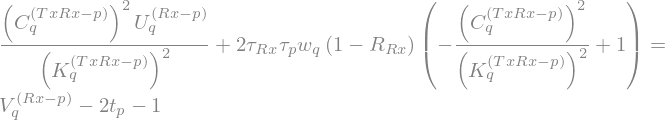

In [80]:
#Substitute in the next equation
eq_variance_2_subs = eq_variance_2.subs([(eta, eta_sol)])
print("substitution of eta:")
eq_variance_2_subs

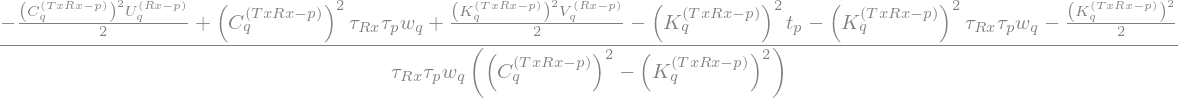

In [81]:
#Substitute solve for R_Rx
R_Rx_sol = sympy.simplify(sympy.solve(eq_variance_2_subs, R_Rx)[0])
R_Rx_sol

substitution of eta and tau_p:


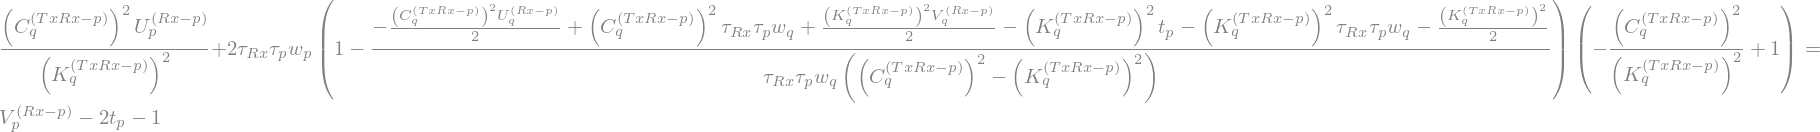

In [82]:
#Substitute in the next equation
eq_variance_3_subs = eq_variance_3.subs([(eta, eta_sol), (R_Rx, R_Rx_sol)])
print("substitution of eta and R_Rx:")
eq_variance_3_subs

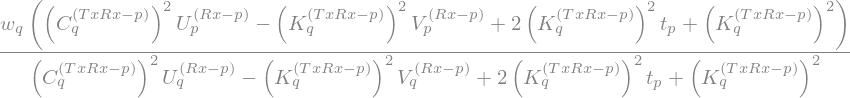

In [83]:
#Substitute solve for w_p
w_p_sol = sympy.simplify(sympy.solve(eq_variance_3_subs, w_p)[0])
w_p_sol

substitution of eta, R_Rx and w_p:


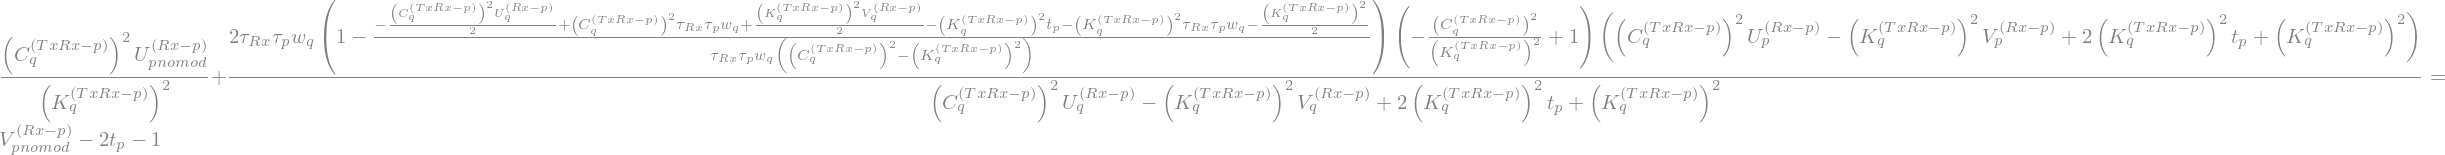

In [85]:
#Substitute in next equation
eq_variance_4_subs = eq_variance_4.subs([(eta, eta_sol), (R_Rx, R_Rx_sol), (w_p, w_p_sol)])
print("substitution of eta, R_Rx and w_p:")
eq_variance_4_subs

In [86]:
#Substitute solve for w_q
w_q_sol = sympy.simplify(sympy.solve(eq_variance_4_subs, w_q)[0])
w_q_sol

IndexError: list index out of range

#### Comments

It doesn't seem to work by substitutions, meaning that sympy.solve(system) is not proceeding by this method.

## Complete Parameter Estimation

#### Scope

Find the maximum number of system parameters through parameter estimation, and leave the least possible number of parameters for direct measurement. The procedure is divided into "back-to-back" and "real transmission".

### Back-to-back parameter estimation
Here the assumption is

\begin{equation}
    \eta = 1
\end{equation}

#### Calculate the expression of the prepare & measure covariance matrix in the back-to-back configuration


- Covariance matrix in the back-to-back configuration:


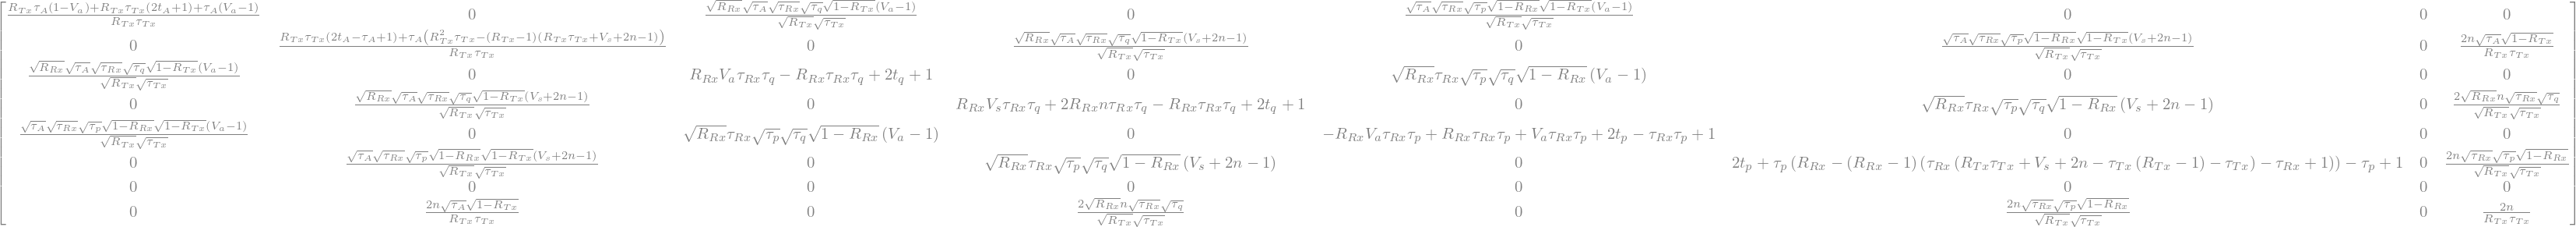

In [59]:
CM_b2b = CM.subs([(eta, 1)])
print("\n- Covariance matrix in the back-to-back configuration:")
sympy.simplify(CM_b2b)

In [102]:
system = (Eq(CM_b2b[0, 0]-V_q_Tx, 0),\
          Eq(CM_b2b[2, 2]-V_q_Rx_q, 0),\
          Eq(CM_b2b[4, 4]-V_q_Rx_p, 0),\
          Eq(CM_b2b[5, 5]-V_p_Rx_p, 0),\
          Eq(CM_b2b[5, 5].subs([(n, 0)])-V_p_nomod_Rx_p, 0),\
          Eq(CM_b2b[0, 2]-C_q_Tx_Rx_q, 0),\
          Eq(CM_b2b[0, 4]-C_q_Tx_Rx_p, 0),\
          Eq(CM_b2b[5, 7]-C_p_mod_Rx_p, 0))

- V^{(Tx)}_q - \frac{V_{a} \tau_{A}}{\tau_{Tx}} + 2 t_{A} + \frac{\tau_{A}}{\tau_{Tx}} + 1 + \frac{V_{a} \tau_{A}}{R_{Tx} \tau_{Tx}} - \frac{\tau_{A}}{R_{Tx} \tau_{Tx}} = 0


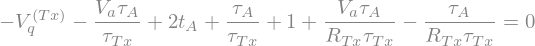

In [64]:
print(latex(system[0]))
system[0]

In [65]:
print(latex(system[1]))
system[1]

R_{Rx} V_{a} \tau_{Rx} \tau_{q} - R_{Rx} \tau_{Rx} \tau_{q} - V^{(Rx-q)}_q + 2 t_{q} + 1 = 0


- V^{(Rx-p)}_q + 2 t_{p} + \tau_{p} \left(R_{Rx} - \left(R_{Rx} - 1\right) \left(\tau_{Rx} \left(R_{Tx} \tau_{Tx} + V_{a} + \tau_{Tx} \left(1 - R_{Tx}\right) - \tau_{Tx}\right) - \tau_{Rx} + 1\right)\right) - \tau_{p} + 1 = 0


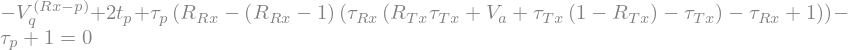

In [66]:
print(latex(system[2]))
system[2]

- V^{(Rx-p)}_p + 2 t_{p} + \tau_{p} \left(R_{Rx} - \left(R_{Rx} - 1\right) \left(\tau_{Rx} \left(R_{Tx} \tau_{Tx} + V_{s} + 2 n + \tau_{Tx} \left(1 - R_{Tx}\right) - \tau_{Tx}\right) - \tau_{Rx} + 1\right)\right) - \tau_{p} + 1 = 0


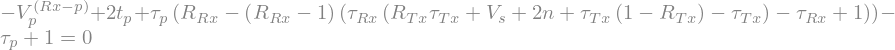

In [67]:
print(latex(system[3]))
system[3]

- V^{(Rx-p)}_{p nomod} + 2 t_{p} + \tau_{p} \left(R_{Rx} - \left(R_{Rx} - 1\right) \left(\tau_{Rx} \left(R_{Tx} \tau_{Tx} + V_{s} + \tau_{Tx} \left(1 - R_{Tx}\right) - \tau_{Tx}\right) - \tau_{Rx} + 1\right)\right) - \tau_{p} + 1 = 0


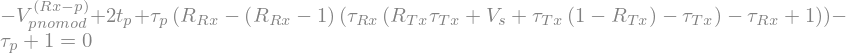

In [68]:
print(latex(system[4]))
system[4]

- C^{(Tx Rx-q)}_q + \frac{\sqrt{R_{Rx}} \sqrt{\tau_{A}} \sqrt{\tau_{Rx}} \sqrt{\tau_{q}} \sqrt{1 - R_{Tx}} \left(V_{a} - 1\right)}{\sqrt{R_{Tx}} \sqrt{\tau_{Tx}}} = 0


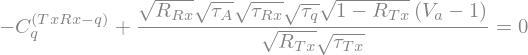

In [69]:
print(latex(system[5]))
system[5]

- C^{(Tx Rx-p)}_q + \frac{\sqrt{\tau_{A}} \sqrt{\tau_{Rx}} \sqrt{\tau_{p}} \sqrt{1 - R_{Rx}} \sqrt{1 - R_{Tx}} \left(V_{a} - 1\right)}{\sqrt{R_{Tx}} \sqrt{\tau_{Tx}}} = 0


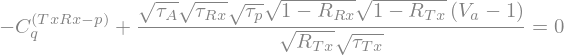

In [70]:
print(latex(system[6]))
system[6]

- C^{(mod Rx-p)}_p + \frac{2 n \sqrt{\tau_{Rx}} \sqrt{\tau_{p}} \sqrt{1 - R_{Rx}}}{\sqrt{R_{Tx}} \sqrt{\tau_{Tx}}} = 0


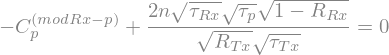

In [71]:
print(latex(system[7]))
system[7]


 Estimated trusted parameters:


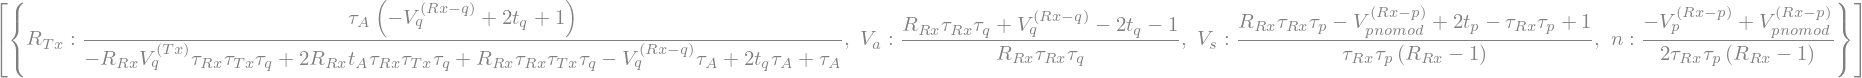

In [103]:
#Estimate thetrusted parameters
parameters = sympy.solve((system[0], system[1], system[3], system[4]), (V_s, V_a, n, R_Tx), dict=True)
print("\n Estimated trusted parameters:")
parameters

In [105]:
print("\n Estimated trusted parameters in lateX format:\n")
print(latex(parameters))


 Estimated trusted parameters in lateX format:

\left[ \left\{ R_{Tx} : \frac{\tau_{A} \left(- V^{(Rx-q)}_q + 2 t_{q} + 1\right)}{- R_{Rx} V^{(Tx)}_q \tau_{Rx} \tau_{Tx} \tau_{q} + 2 R_{Rx} t_{A} \tau_{Rx} \tau_{Tx} \tau_{q} + R_{Rx} \tau_{Rx} \tau_{Tx} \tau_{q} - V^{(Rx-q)}_q \tau_{A} + 2 t_{q} \tau_{A} + \tau_{A}}, \  V_{a} : \frac{R_{Rx} \tau_{Rx} \tau_{q} + V^{(Rx-q)}_q - 2 t_{q} - 1}{R_{Rx} \tau_{Rx} \tau_{q}}, \  V_{s} : \frac{R_{Rx} \tau_{Rx} \tau_{p} - V^{(Rx-p)}_{p nomod} + 2 t_{p} - \tau_{Rx} \tau_{p} + 1}{\tau_{Rx} \tau_{p} \left(R_{Rx} - 1\right)}, \  n : \frac{- V^{(Rx-p)}_p + V^{(Rx-p)}_{p nomod}}{2 \tau_{Rx} \tau_{p} \left(R_{Rx} - 1\right)}\right\}\right]


In [106]:
print("\n Estimated trusted parameters in python format:\n")
print(parameters)


 Estimated trusted parameters in python format:

[{V_s: (R_Rx*tau_Rx*tau_p - V^{(Rx-p)}_{p nomod} + 2*t_p - tau_Rx*tau_p + 1)/(tau_Rx*tau_p*(R_Rx - 1)), V_a: (R_Rx*tau_Rx*tau_q + V^{(Rx-q)}_q - 2*t_q - 1)/(R_Rx*tau_Rx*tau_q), n: (-V^{(Rx-p)}_p + V^{(Rx-p)}_{p nomod})/(2*tau_Rx*tau_p*(R_Rx - 1)), R_Tx: tau_A*(-V^{(Rx-q)}_q + 2*t_q + 1)/(-R_Rx*V^{(Tx)}_q*tau_Rx*tau_Tx*tau_q + 2*R_Rx*t_A*tau_Rx*tau_Tx*tau_q + R_Rx*tau_Rx*tau_Tx*tau_q - V^{(Rx-q)}_q*tau_A + 2*t_q*tau_A + tau_A)}]


### Real measurement parameter estimation

Assuming the above parameters have been estimated in a back-to-back measurement, we proceed estimating the untrusted parameters $\eta$, $w_q$, $w_p$ and the remaining parameters $\tau_\text{Tx}$ and $\tau_\text{Rx}$.



In [111]:
system = (Eq(CM[0, 0]-V_q_Tx, 0),\
          Eq(CM[2, 2]-V_q_Rx_q, 0),\
          Eq(CM[4, 4]-V_q_Rx_p, 0),\
          Eq(CM[5, 5]-V_p_Rx_p, 0),\
          Eq(CM[5, 5].subs([(n, 0)])-V_p_nomod_Rx_p, 0),\
          Eq(CM[0, 2]-C_q_Tx_Rx_q, 0),\
          Eq(CM[0, 4]-C_q_Tx_Rx_p, 0),\
          Eq(CM[5, 7]-C_p_mod_Rx_p, 0))

- V^{(Tx)}_q - \frac{V_{a} \tau_{A}}{\tau_{Tx}} + 2 t_{A} + \frac{\tau_{A}}{\tau_{Tx}} + 1 + \frac{V_{a} \tau_{A}}{R_{Tx} \tau_{Tx}} - \frac{\tau_{A}}{R_{Tx} \tau_{Tx}} = 0


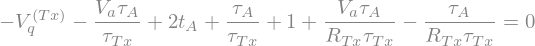

In [84]:
print(latex(system[0]))
system[0]

R_{Rx} V_{a} \eta \tau_{Rx} \tau_{q} - 2 R_{Rx} \eta \tau_{Rx} \tau_{q} w_{q} - R_{Rx} \eta \tau_{Rx} \tau_{q} + 2 R_{Rx} \tau_{Rx} \tau_{q} w_{q} - V^{(Rx-q)}_q + 2 t_{q} + 1 = 0


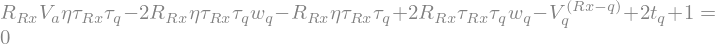

In [85]:
print(latex(system[1]))
system[1]

- V^{(Rx-p)}_q + 2 t_{p} + \tau_{p} \left(R_{Rx} - \left(R_{Rx} - 1\right) \left(\tau_{Rx} \left(\eta \left(R_{Tx} \tau_{Tx} + V_{a} + \tau_{Tx} \left(1 - R_{Tx}\right) - \tau_{Tx}\right) - \left(\eta - 1\right) \left(2 w_{q} + 1\right)\right) - \tau_{Rx} + 1\right)\right) - \tau_{p} + 1 = 0


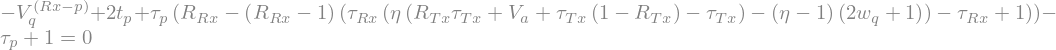

In [86]:
print(latex(system[2]))
system[2]

- V^{(Rx-p)}_p + 2 t_{p} + \tau_{p} \left(R_{Rx} - \left(R_{Rx} - 1\right) \left(\tau_{Rx} \left(\eta \left(R_{Tx} \tau_{Tx} + V_{s} + 2 n + \tau_{Tx} \left(1 - R_{Tx}\right) - \tau_{Tx}\right) - \left(\eta - 1\right) \left(2 w_{p} + 1\right)\right) - \tau_{Rx} + 1\right)\right) - \tau_{p} + 1 = 0


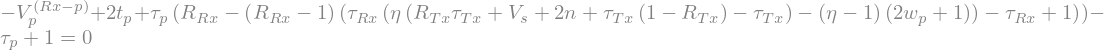

In [87]:
print(latex(system[3]))
system[3]

- V^{(Rx-p)}_{p nomod} + 2 t_{p} + \tau_{p} \left(R_{Rx} - \left(R_{Rx} - 1\right) \left(\tau_{Rx} \left(\eta \left(R_{Tx} \tau_{Tx} + V_{s} + \tau_{Tx} \left(1 - R_{Tx}\right) - \tau_{Tx}\right) - \left(\eta - 1\right) \left(2 w_{p} + 1\right)\right) - \tau_{Rx} + 1\right)\right) - \tau_{p} + 1 = 0


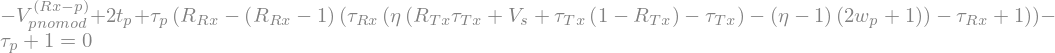

In [88]:
print(latex(system[4]))
system[4]

- C^{(Tx Rx-q)}_q + \frac{\sqrt{R_{Rx}} \sqrt{\eta} \sqrt{\tau_{A}} \sqrt{\tau_{Rx}} \sqrt{\tau_{q}} \sqrt{1 - R_{Tx}} \left(V_{a} - 1\right)}{\sqrt{R_{Tx}} \sqrt{\tau_{Tx}}} = 0


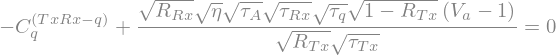

In [89]:
print(latex(system[5]))
system[5]

- C^{(Tx Rx-p)}_q + \frac{\sqrt{\eta} \sqrt{\tau_{A}} \sqrt{\tau_{Rx}} \sqrt{\tau_{p}} \sqrt{1 - R_{Rx}} \sqrt{1 - R_{Tx}} \left(V_{a} - 1\right)}{\sqrt{R_{Tx}} \sqrt{\tau_{Tx}}} = 0


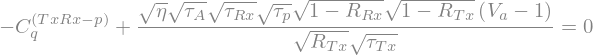

In [90]:
print(latex(system[6]))
system[6]

- C^{(mod Rx-p)}_p + \frac{2 \sqrt{\eta} n \sqrt{\tau_{Rx}} \sqrt{\tau_{p}} \sqrt{1 - R_{Rx}}}{\sqrt{R_{Tx}} \sqrt{\tau_{Tx}}} = 0


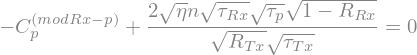

In [91]:
print(latex(system[7]))
system[7]


- Estimated untrusted parameters:


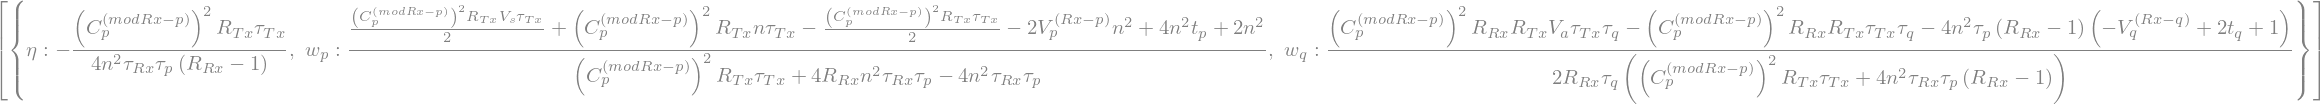

In [108]:
#Estimate parameters
parameters = sympy.solve((system[7], system[1], system[3]), (eta, w_q, w_p), dict=True)
print("\n- Estimated untrusted parameters:")
parameters

In [109]:
print("\n Estimated untrusted parameters in lateX format:\n")
print(latex(parameters))


 Estimated untrusted parameters in lateX format:

\left[ \left\{ \eta : - \frac{\left(C^{(mod Rx-p)}_p\right)^{2} R_{Tx} \tau_{Tx}}{4 n^{2} \tau_{Rx} \tau_{p} \left(R_{Rx} - 1\right)}, \  w_{p} : \frac{\frac{\left(C^{(mod Rx-p)}_p\right)^{2} R_{Tx} V_{s} \tau_{Tx}}{2} + \left(C^{(mod Rx-p)}_p\right)^{2} R_{Tx} n \tau_{Tx} - \frac{\left(C^{(mod Rx-p)}_p\right)^{2} R_{Tx} \tau_{Tx}}{2} - 2 V^{(Rx-p)}_p n^{2} + 4 n^{2} t_{p} + 2 n^{2}}{\left(C^{(mod Rx-p)}_p\right)^{2} R_{Tx} \tau_{Tx} + 4 R_{Rx} n^{2} \tau_{Rx} \tau_{p} - 4 n^{2} \tau_{Rx} \tau_{p}}, \  w_{q} : \frac{\left(C^{(mod Rx-p)}_p\right)^{2} R_{Rx} R_{Tx} V_{a} \tau_{Tx} \tau_{q} - \left(C^{(mod Rx-p)}_p\right)^{2} R_{Rx} R_{Tx} \tau_{Tx} \tau_{q} - 4 n^{2} \tau_{p} \left(R_{Rx} - 1\right) \left(- V^{(Rx-q)}_q + 2 t_{q} + 1\right)}{2 R_{Rx} \tau_{q} \left(\left(C^{(mod Rx-p)}_p\right)^{2} R_{Tx} \tau_{Tx} + 4 n^{2} \tau_{Rx} \tau_{p} \left(R_{Rx} - 1\right)\right)}\right\}\right]


In [110]:
print("\n Estimated untrusted parameters in python format:\n")
print(parameters)


 Estimated untrusted parameters in python format:

[{eta: -C^{(mod Rx-p)}_p**2*R_Tx*tau_Tx/(4*n**2*tau_Rx*tau_p*(R_Rx - 1)), w_p: (C^{(mod Rx-p)}_p**2*R_Tx*V_s*tau_Tx/2 + C^{(mod Rx-p)}_p**2*R_Tx*n*tau_Tx - C^{(mod Rx-p)}_p**2*R_Tx*tau_Tx/2 - 2*V^{(Rx-p)}_p*n**2 + 4*n**2*t_p + 2*n**2)/(C^{(mod Rx-p)}_p**2*R_Tx*tau_Tx + 4*R_Rx*n**2*tau_Rx*tau_p - 4*n**2*tau_Rx*tau_p), w_q: (C^{(mod Rx-p)}_p**2*R_Rx*R_Tx*V_a*tau_Tx*tau_q - C^{(mod Rx-p)}_p**2*R_Rx*R_Tx*tau_Tx*tau_q - 4*n**2*tau_p*(R_Rx - 1)*(-V^{(Rx-q)}_q + 2*t_q + 1))/(2*R_Rx*tau_q*(C^{(mod Rx-p)}_p**2*R_Tx*tau_Tx + 4*n**2*tau_Rx*tau_p*(R_Rx - 1)))}]


# Secret Key Rate 


In this section, the secret key rate $R$ is estimated through the following:

\begin{equation}
    R = \beta I\left(A:B\right) - \chi_{EB}
\end{equation}

where $I\left(A:B\right)$ is the Shannon mutual information of the transmitter's generated QKD symbols and the modulated quadrature measured at the receiver's homodyne detector $\hat{p}$, $\beta\in [0, 1]$ is the error correction efficiency and 

\begin{equation}
    \chi_{EB} = S\left(\hat{\rho}_{E}\right) - S\left(\hat{\rho}_{E}|\hat{\rho}_{B}\right)
\end{equation}

is the Holevo information, which is an upper bound to the amount of information obtained by the eavesdropper after attacking the QKD system. Assuming the asymmetric entangling cloner attack is optimal in the asymptotic limit for this system (is this only a conjecture?????), then it is possible to compute $\chi_{EB}$ given the fact that the state prepared by the eavesdropper is an asymmetric two-mode squeezed state and given homodyne detection at the receiver. $S$ is the von Neumann entropy of information for the quantum state $\hat{\rho}$. By Holevo's theorem (1999), the von Neumann entropy of an $N$-mode Gaussian quantum state with covariance matrix $\mathbf{V}$ is
					
\begin{equation}
    S\left(\hat{\rho}\right) = \sum\limits_{k=1}^{N}g(\nu_k)
\end{equation}

where

\begin{equation}
    g(x) = \left(\frac{x+1}{2}\right)\log\left(\frac{x+1}{2}\right) - 
            \left(\frac{x-1}{2}\right)\log\left(\frac{x-1}{2}\right)
\end{equation}

and $\{\nu_k\}_{k=1}^{N}$ are the symplectic eigenvalues of $\mathbf{V}$, which are the distinct modulii of the eigenvalues of the matrix

\begin{equation}
    i\mathbf{\Omega} \mathbf{V}
\end{equation}

and

\begin{equation}
    \mathbf{\Omega} = \bigoplus\limits_{j=1}^{N} \mathbf{\omega} \qquad \mathbf{\omega} = 
    \begin{pmatrix}
       0 & 1\\
       -1 & 0\\
    \end{pmatrix}
\end{equation}

Here, $S\left(\hat{\rho}_{E}\right)$ is the von Neumann entropy of the joint quantum state $\hat{\rho}_{E}=\hat{\rho}_{E_1E_2B}$ (where $E_1$ and $E_2$ are the two modes of the eavesdropper), with covariance matrix $\mathbf{V}_{E}$, while  $S\left(\hat{\rho}_{E}|\hat{\rho}_{B}\right)$ is the von Neumann entropy of the same quantum state, after performing homodyne detection on the receiver mode $B$.

The following section constructs the entanglement-based covariance matrix $\mathbf{V}_{E_1E_2B}$ to compute  $\chi_{EB}$ and $R$, letting $\beta$ vary as a free parameter.

## The Mutual Information $I\left(A:B\right)$

For a Gaussian modulation over a Gaussian channel, $I\left(A:B\right)$ can be found from the prepare & measure covariance matrix:

\begin{equation}
    I\left(A:B\right) = -\frac{1}{2}\log\left(1-\frac{z^2_p}{2 n y_p}\right)
\end{equation}

In words, the mutual information is the Shannon's mutual information of the $\hat{p}$ quadrature (into which information is encoded) at transmitter and receiver; it is given by the differential Shannon entropy of two Gaussian random variables, with variances $2 n$ (the QKD symbols) and $y_p$ (the $\hat{p}$ quadrature measured at the receiver's homodyne detector), and with covariance $z_p$.

## Entanglement-Based Scheme

The following diagram shows the entanglement-based version of the present QKD system.

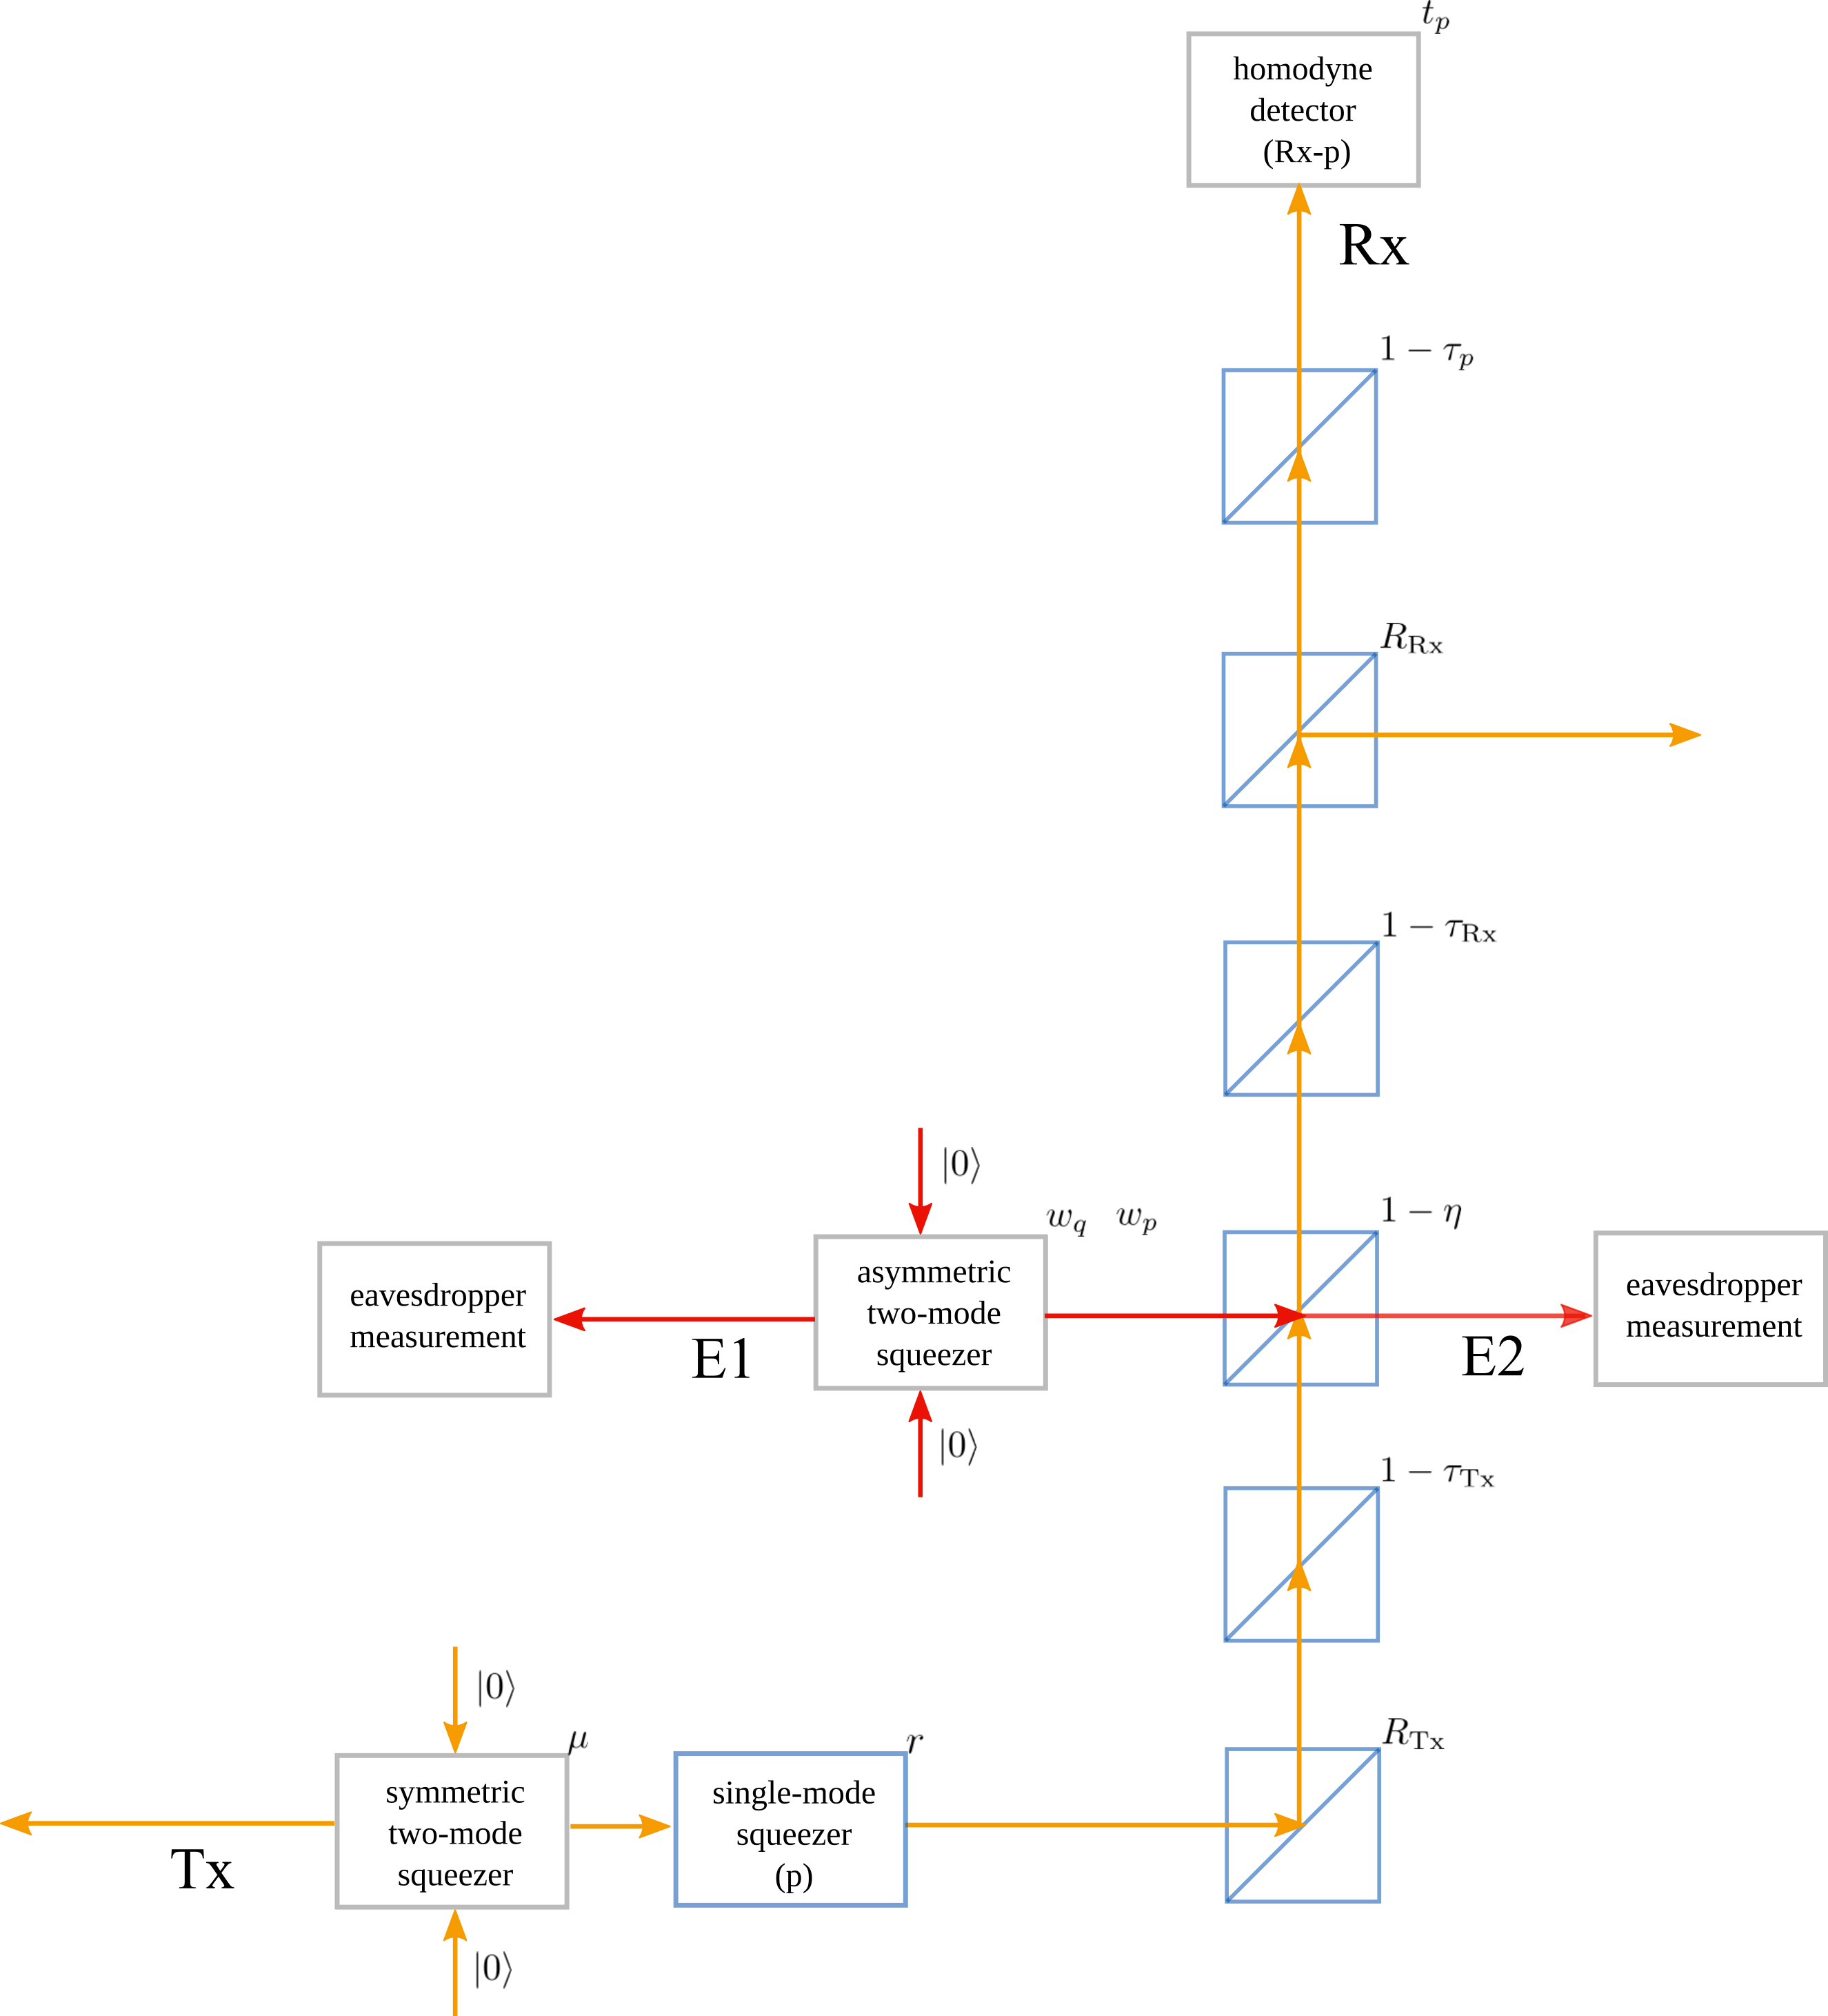

In [43]:
Image("Figures/Squeezed-States-QKD_schematic-system-level_entanglement-based.png", width=800)

## Entanglement-Based Covariance Matrix

### Define symbols of the entanglement-based scheme

- $\mu$: variances of the quadratures the two-mode squeezed state prepared at the transmitter; 
- $c_\mu$: inter-quadrature covariance of the two-mode squeezed state prepared at the transmitter;
- $r$: single-mode squeezing parameter;
- $V_\epsilon$: variance of the excess antisqueezing, arising from the single-mode squeezing operation.

In [134]:
r, mu, V_epsilon = sympy.symbols("r mu V_epsilon", real=True, nonnegative=True)
c_mu = sympy.symbols("c_mu", real=True)

### Initialize the covariance matrix in a vacuum state

Initial entanglement-based covariance matrix:


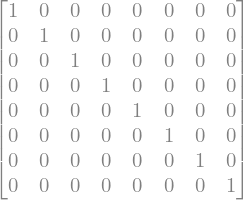

In [135]:
CM_EB = Vacuum(4)
print("Initial entanglement-based covariance matrix:")
sympy.simplify(CM_EB)

### Define the two-mode squeezed state at the transmitter


Entanglement-based covariance matrix after defining the signal two-mode squeeezed state at the transmitter.


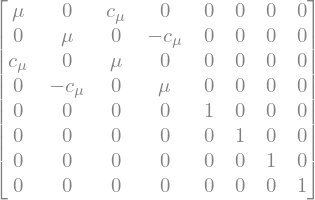

In [136]:
CM_EB[0, 0] = CM_EB[1, 1] = CM_EB[2, 2] = CM_EB[3, 3] = mu, 
CM_EB[2, 0] = CM_EB[0, 2] = c_mu
CM_EB[3, 1] = CM_EB[1, 3] = -c_mu
print("\nEntanglement-based covariance matrix after defining the signal two-mode squeeezed state at the transmitter.")
sympy.simplify(CM_EB)

### Squeeze one mode of the two-mode squeezed state


Entanglement-based covariance matrix after squeezing the second mode of the signal.


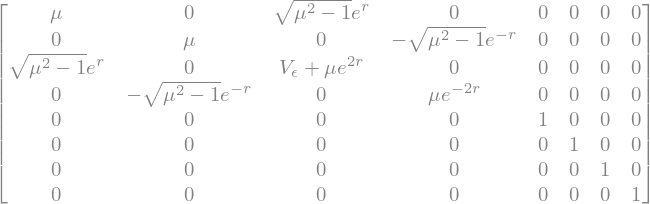

In [137]:
CM_EB = CM_EB.squeeze(0, -r, 0, 0)
CM_EB[2, 2] += V_epsilon  #variance of the antisqueezed quadrature if the impure squeezed state
print("\nEntanglement-based covariance matrix after squeezing the second mode of the signal.")
CM_EB = CM_EB.subs([(c_mu, sympy.sqrt(mu**2-1))])
sympy.simplify(CM_EB)

## Relation between the prepare & measure parameters and the entanglement-based ones at the transmitter

The parameters $\mu$, $r$ and $V_\epsilon$ depend on the prepare & measure squeezing variance $V_{s_0}$ and on the modulation mean photon number $n$. To derive these dependencies, let's start by stating that the variance of the antisqueezed quadrature at the displacement beam splitter output, $V_{a_0}$ can be written as

\begin{equation}
    V_{a_0} = \frac{1}{V_{s_0}} + V_\epsilon
\end{equation}

i.e., it deviates from the inverse of the variance of the squeezed quadrature $V_{s_0}$ by an excess noise $V_\epsilon$.
On the other hand, the inverse of $V_{s_0}$ is given by the ideal antisqueezed quadrature variance

\begin{equation}
    \frac{1}{V_{s_0}} = \mu e^{2r}
\end{equation}

which yields

\begin{equation}
    V_\epsilon + \mu e^{2r} = V_{a_0}
\end{equation}

The variance of the modulated squeezed quadrature is

\begin{equation}
    V_{s_0}+2n_0 = \mu e^{-2r} 
\end{equation}

Solving the system made of the last two equations for $\mu$ and $r$ yields

\begin{equation}
    \begin{aligned}  
        r &= -\frac{1}{4} \log\left(V_{s_0}\left(V_{s_0}+2n_0\right)\right) \\
        \mu &= \sqrt{1+\frac{2n_0}{V_{s_0}}}
    \end{aligned}
\end{equation}

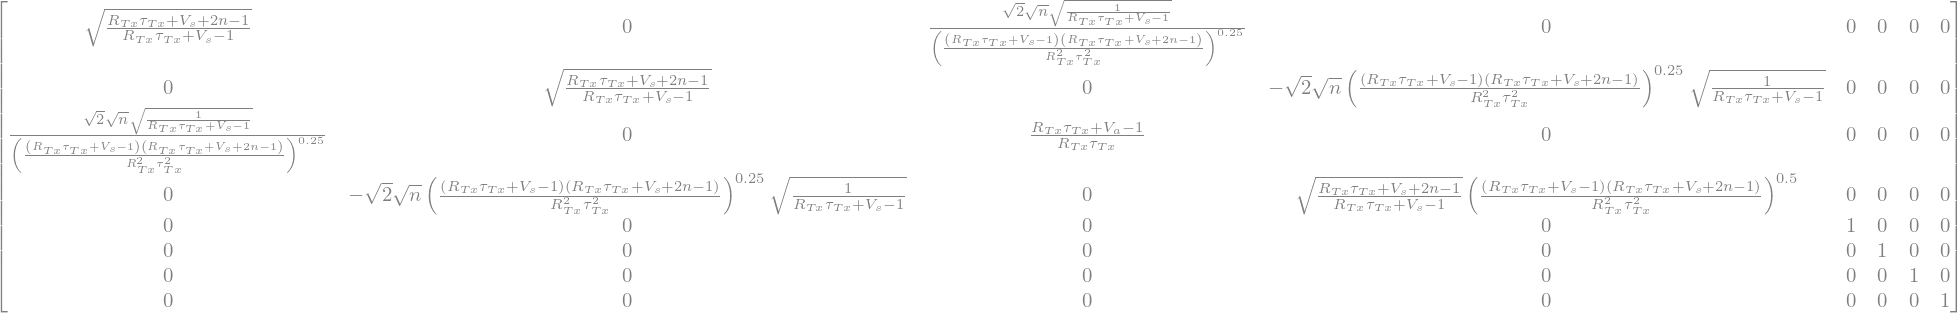

In [138]:
#Substitute the expressions of the entanglement-based parameters mu, r and V_epsilon 
#as functions of the prepare and measure ones
CM_EB[2, 2] = V_a_0 = (V_a-(1-tau_Tx*R_Tx))/(tau_Tx*R_Tx)
V_s_0 = (V_s-(1-tau_Tx*R_Tx))/(tau_Tx*R_Tx)
n_0 = n/(tau_Tx*R_Tx)
CM_EB = CM_EB.subs([(r, -1/4*sympy.log(V_s_0*(V_s_0+2*n_0)))])
CM_EB = CM_EB.subs([(mu, sympy.sqrt(1+2*n_0/(V_s_0)))])
sympy.simplify(CM_EB)

## Define the asymmetric two-mode squeezed state at the eavesdropper


Entanglement-based covariance matrix after defining the eavesdropper's asymmetric two-mode squeezed state.


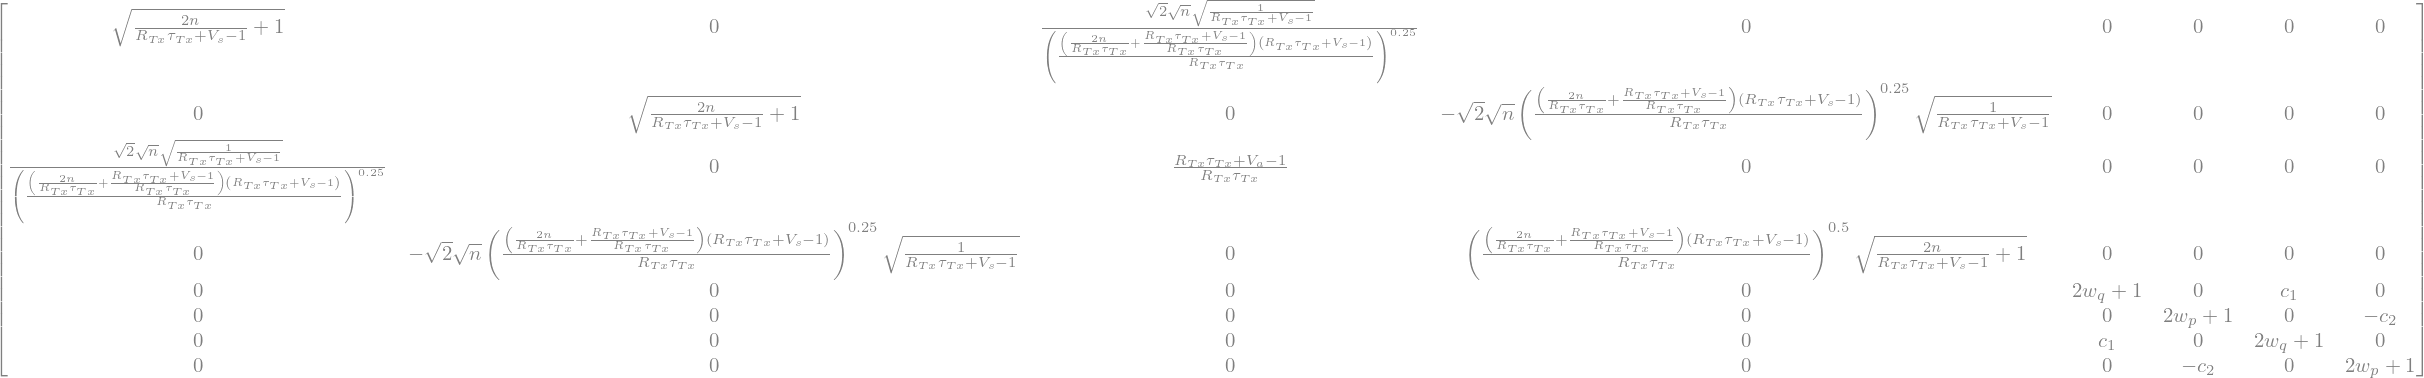

In [269]:
CM_EB[4:8, 4:8] = [[2*w_q+1, 0, c_1, 0], [0, 2*w_p+1, 0, -c_2], [c_1, 0, 2*w_q+1, 0], [0, -c_2, 0, 2*w_p+1]] 
print("\nEntanglement-based covariance matrix after defining the eavesdropper's asymmetric two-mode squeezed state.")
CM_EB

## Propagate the squeezed signal to the channel input


Entanglement-based covariance matrix after propagating the squeezed signal to the channel input.


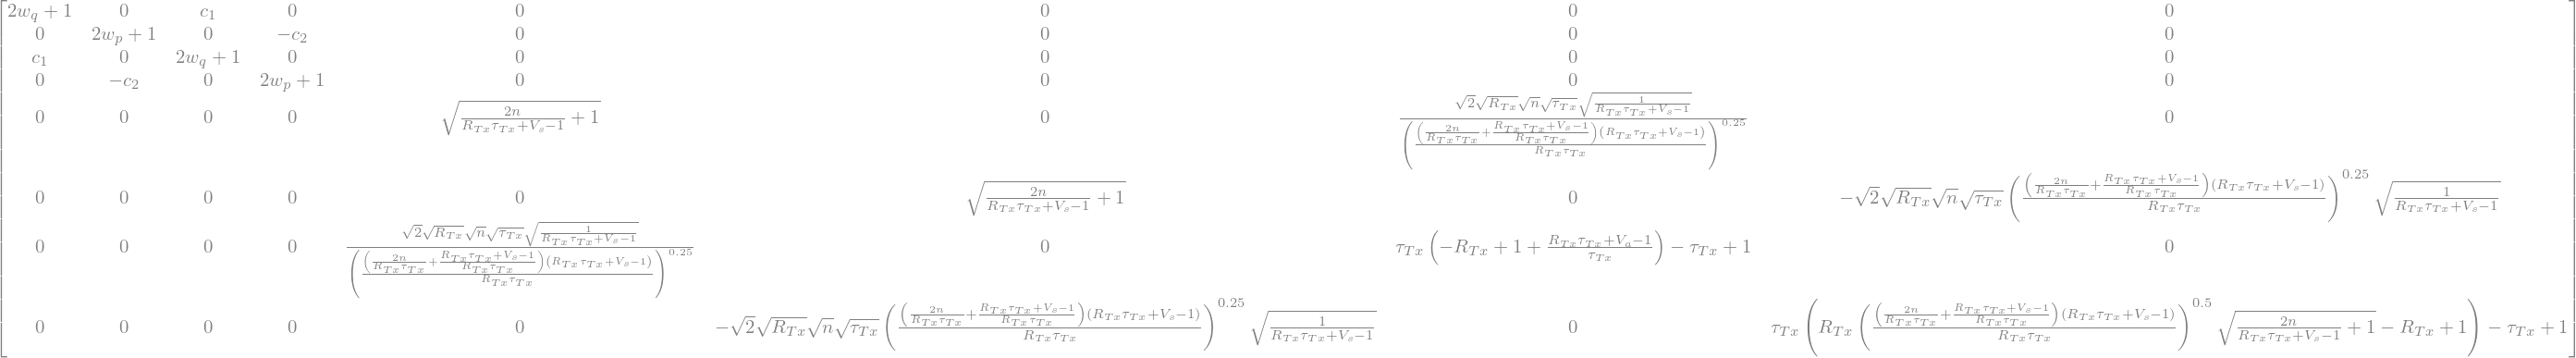

In [270]:
CM_EB = CM_EB.opticalefficiency(1, R_Tx, 1, 1)
CM_EB = CM_EB.opticalefficiency(1, tau_Tx, 1, 1)
#Re-order the modes for convenience in further beam splitting operations
CM_EB = CM_EB.pick_modes(3, 4, 1, 2)
print("\nEntanglement-based covariance matrix after propagating the squeezed signal to the channel input.")
CM_EB

## Interfere the squeezed signal with the second eavesdropper's mode on the channel


Entanglement-based covariance matrix after interfering the squeezed signal with the second eavesdropper's mode.


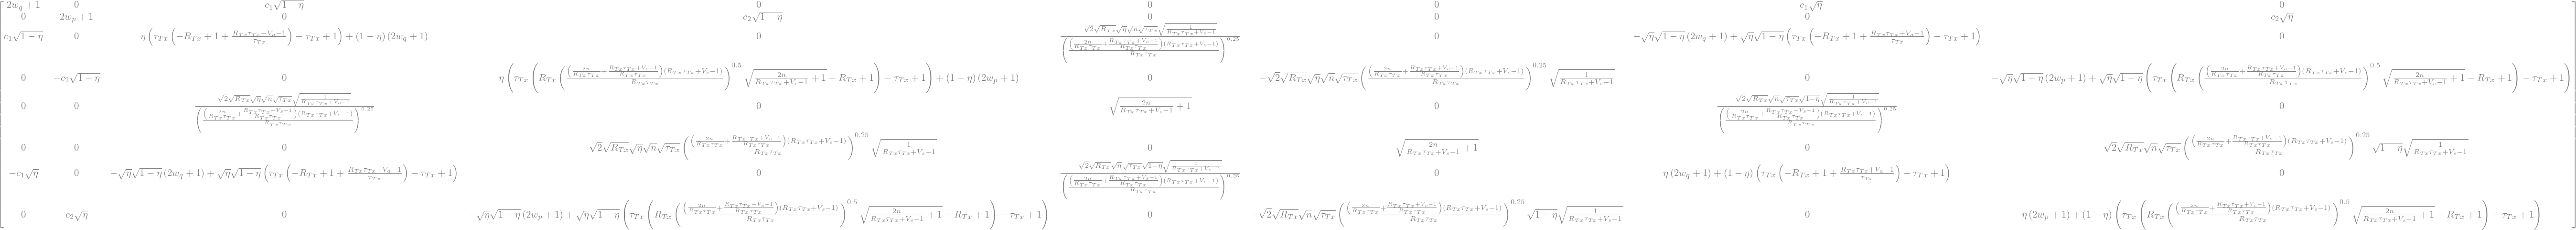

In [271]:
CM_EB = CM_EB.bs(2, 4, R=1-eta)
print("\nEntanglement-based covariance matrix after interfering the squeezed signal with the second eavesdropper's mode.")
CM_EB 

## Propagate the squeezed signal from the channel output to the $\hat{p}$ homodyne detector input


Entanglement-based covariance matrix after propagation to the receiver's homodyne detector p.


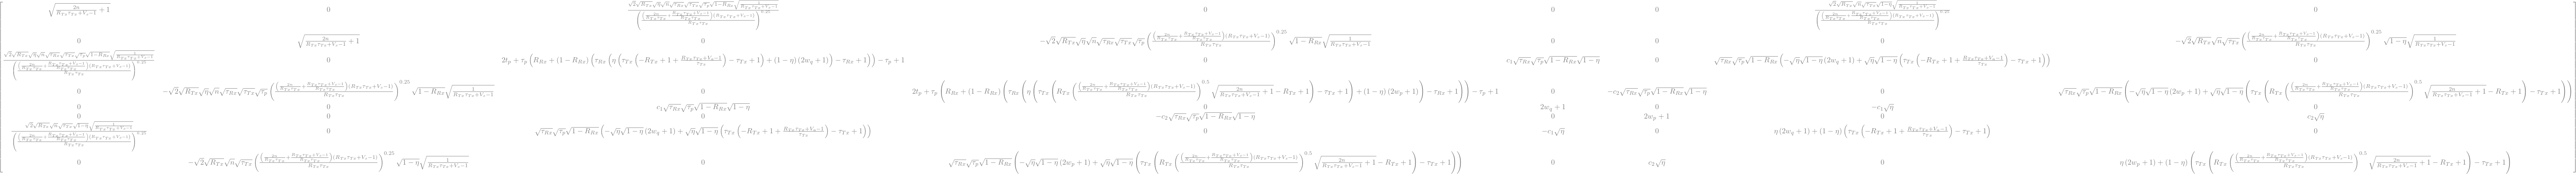

In [272]:
#Re-order the modes as follows:

#1. A: first signal mode at the transmitter, not propagating towards the receiver;
#2. B: signal mode propagating towards the receiver's homodyne detector p;
#3. E_1: first eavesdropper's mode, not interferring on the channel;
#4. E_2: second eavesdropper's mode, after interference with the signal on the channel;
CM_EB = CM_EB.pick_modes(3, 2, 1, 4)

#Propagate the squeezed signal from the channel output to the homodyne detector input
CM_EB = CM_EB.opticalefficiency(1, tau_Rx, 1, 1)
CM_EB = CM_EB.opticalefficiency(1, 1-R_Rx, 1, 1)
CM_EB = CM_EB.opticalefficiency(1, tau_p, 1, 1)
#Include the trusted homodyne detector noise
CM_EB[2, 2] += 2*t_p
CM_EB[3, 3] += 2*t_p

print("\nEntanglement-based covariance matrix after propagation to the receiver's homodyne detector p.")
CM_EB

# Calculation of the Holevo Information $\chi_{EB}$

## von Neumann Entropy $S\left(\hat{\rho}_{E}\right)$

In [ ]:
#Calculate the symplectic matrix of the entanglement-based covariance matrix
#omega = [[0, 1], [-1, 0]]
#Omega = sympy.diag(omega, omega) #basic symplectic matrix
#V_EB_E = CM_EB.pick_modes(3, 4) #eavesdropper state's covariance matrix
#ni_E = sympy.simplify((sympy.I*Omega*V_EB_E).eigenvals())
print("\nEigenvalues of the matrix (i Omega V_E):\n")
#print(latex(ni_E))

## von Neumann Entropy $S\left(\hat{\rho}_{E}|\hat{\rho}_{B}\right)$

In [ ]:
#Calculate the covariance matrix of the eavesdropper's modes after homodyne detection on mode B, measuring the p quadrature
V_B = CM_EB.pick_modes(2) #covariance matrix of the signal mode at the receiver's homodyne detector input
V_EB_EB = CM_EB.pick_modes(2, 3, 4) #covariance matrix of the joint state of system BE
print("\nCovariance matrix of the joint system EB:")
V_EB_EB

In [ ]:
C_EB = V_EB_EB[2:6, 0:2] #off-diagonal block, containing the covariances between the state of systems E and B
print("\nOff-diagonal block, containing the covariances between the state of system E and system B")
C_EB

In [ ]:
Pi = sympy.Matrix([[0, 0],[0, 1]]) #projection matrix onto the p quadrature
V_E = V_EB_EB.pick_modes(2, 3) #covariance matrix of the state of system E
V_EB_E_given_B = V_E - C_EB*(Pi*V_B*Pi).pinv()*C_EB.T #covariance matrix of the state of E, after homodyne detection on the mode B
print("\nCovariance matrix of the state of E, after homodyne detection on the mode B")
V_EB_E_given_B

In [ ]:
#Calculate the symplectic eivenvalues of V_{EB} given homodyne detection on B
#ni_E_given_B = sympy.simplify((sympy.I*Omega*V_EB_E_given_B).eigenvals())
print("\nEigenvalues of the matrix (i Omega V_E):\n")
#print(latex(ni_E))